In [33]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import optax as ox
import jax
import cola

from jaxtyping import (
    Float,
)
from gpjax.typing import (
    Array,
    ScalarFloat,
)
import jax.numpy as jnp
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
from jax import jit, config, grad, hessian

from functions import calculate_std

import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.base import param_field, static_field
from functools import partial

config.update("jax_enable_x64", True)

# set jnp random key
key = jr.PRNGKey(42)

In [34]:
########################################## edit the parameters here ##########################################

# define the parameters of the model
dt = 0.001

# define noise, which is the variance of the noise in the data
noise = 0.01

# number of test points
n_test = 31
n_boundary = 2

In [35]:
#read from the json file
with open('../../testdata/burger_eqn.json','r') as f:
    data = json.load(f)
    datax = jnp.array(data['x'])
    datau = jnp.array(data['u'])

In [36]:
# save the true solution
u = datau.copy()

# add gaussain nosie to the data
u_new = datau + jnp.sqrt(noise) * jr.normal(key, datau.shape)
x_new = datax

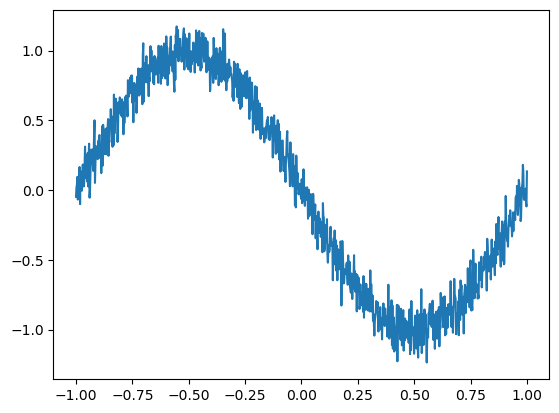

In [37]:
# plot u_new
plt.plot(x_new, u_new[0], label='noisy data')
plt.show()

In [38]:
# select n random points that is spaced out 
n_points = 31
idx = np.random.choice(len(datax), n_points, replace=True)
idx = jnp.linspace(0, len(x_new)-1, n_points).astype(int)

In [39]:
# training data
x_train = jnp.hstack([x_new[idx].T, x_new[idx].T]).T
t_train = jnp.hstack([jnp.array([0]*n_points),jnp.array([1]*n_points)]).T
mu_train = jnp.hstack([u_new[0,idx], u_new[0,idx]]).T

X_train = jnp.vstack([x_train.T,t_train,mu_train]).T
u_train = jnp.hstack([u_new[0,idx].T, u_new[10,idx].T]).reshape(-1,1)

In [40]:
# testing data
x_test = jnp.hstack([x_new.T, x_new.T]).T
t_test = jnp.hstack([jnp.array([0]*len(x_new)),jnp.array([1]*len(x_new))]).T
mu_test = jnp.hstack([u_new[0,:], u_new[0,:]]).T

X_test = jnp.vstack([x_test.T,t_test,mu_test]).T
u_test = jnp.hstack([u_new[0,:].T, u_new[10,:].T]).reshape(-1,1)


In [41]:
dataset_train = gpx.Dataset(X_train, u_train)
dataset_test = gpx.Dataset(X_test, u_test)

In [42]:
print (dt)

0.001


In [43]:
@dataclass
class BurgerKernel(gpx.kernels.AbstractKernel):
    # define the base kernel
    # kernel: gpx.kernels.AbstractKernel = non_stationary_Kernel(active_dims=[0], name="non_stationary_kernel")
    kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0], name="rbf_kernel")
    
    # add parameters for the kernel
    nu: ScalarFloat = param_field(jnp.array(0.01/jnp.pi), trainable = False, bijector=tfb.Softplus())
    delta_t: ScalarFloat = param_field(jnp.array(dt), trainable = False, bijector=tfb.Softplus())
    
    @jax.jit
    def __call__(
        self, 
        X: Float[Array, "1 D"], 
        Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:

        # compute the kernel matrix as a block matrix
        z = jnp.array(X[1], dtype=int)
        zp = jnp.array(Xp[1], dtype=int)

        # mu has the third dimension in X
        mu = jnp.array(X[2], dtype=jnp.float64)
        mu_p = jnp.array(Xp[2], dtype=jnp.float64)

        # X and Xp
        X = jnp.array(X[0:1], dtype=jnp.float64)
        Xp = jnp.array(Xp[0:1], dtype=jnp.float64)

        # switch_0_0 is 1 when z == zp == 0, 0 otherwise
        switch_0_0 = jnp.where((z == 0) & (zp == 0), 1, 0)
        switch_0_1 = jnp.where((z == 0) & (zp == 1), 1, 0)
        switch_1_0 = jnp.where((z == 1) & (zp == 0), 1, 0)
        switch_1_1 = jnp.where((z == 1) & (zp == 1), 1, 0)

        # evaluate the kernel
        k = self.kernel(X, Xp)

        # gradient of the kernel
        # grad_kernel = jnp.array(grad(self.kernel)(X, Xp), dtype=jnp.float64)
        grad_kernel = k * (- (X - Xp)/self.kernel.lengthscale**2)
        
        # hessian of the kernel
        # hess_kernel = jnp.array(hessian(self.kernel)(X, Xp), dtype=jnp.float64)
        hess_kernel = k * ((X -Xp)**2/self.kernel.lengthscale**4 - 1/self.kernel.lengthscale**2)
        
        # hessian of the gradient of the kernel (3rd order derivative)
        # hess_grad_kernel = jnp.array(hessian(grad(self.kernel))(X, Xp), dtype=jnp.float64)
        hess_grad_kernel = k * (3*(X - Xp)/self.kernel.lengthscale**4 -(X-Xp)**3/self.kernel.lengthscale**6)

        # hessian of the hessian of the kernel
        # hess_hess_kernel = jnp.array(hessian(hessian(self.kernel))(X, Xp), dtype=jnp.float64)
        hess_hess_kernel = k * (3/self.kernel.lengthscale**4 - 6*(X - Xp)**2/self.kernel.lengthscale**6 + (X - Xp)**4/self.kernel.lengthscale**8)


        # kernel matrix
        kernel_1_1 = k

        kernel_1_0 = (k
                        + self.delta_t * mu_p * grad_kernel * (-1)
                        - self.delta_t * self.nu * hess_kernel 
                        )
        
        kernel_0_1 = (k
                        + self.delta_t * mu * grad_kernel
                        - self.delta_t * self.nu * hess_kernel
                        )

        kernel_0_0 = (k
                        + self.delta_t * mu_p * grad_kernel * (-1)
                        - self.delta_t * self.nu * hess_kernel 
                        + self.delta_t * mu * grad_kernel
                        - self.delta_t * self.nu * hess_kernel
                        + self.delta_t**2 * mu * mu_p * hess_kernel * (-1)
                        - self.nu * self.delta_t**2 * mu_p * hess_grad_kernel * (-1)
                        - self.nu * self.delta_t**2 * mu * hess_grad_kernel 
                        + self.nu**2 * self.delta_t**2 * hess_hess_kernel 
                        )

        return (switch_0_0 * kernel_0_0 + switch_0_1 * kernel_0_1 + switch_1_0 * kernel_1_0 + switch_1_1 * kernel_1_1).squeeze()

In [44]:
#define the mean and kernel functions
mean = gpx.mean_functions.Zero()
kernel = BurgerKernel()

# Construct GP prior
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)

# Construct GP likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints = n_points, obs_stddev=np.sqrt(noise))

# Construct the posterior
posterior = prior * likelihood

# define the log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

In [45]:
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=dataset_train,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters=10000,
    key=key,
    safe = False
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
# boundary terms
bt_idx = jnp.linspace(0, len(u_new[0])-1, n_boundary).astype(int)
idx = jnp.linspace(0, len(x_new)-1, n_test).astype(int)

t_train = jnp.hstack([jnp.array([0]*n_test),jnp.array([1]*n_boundary)]).T
x_train = jnp.hstack([x_new[idx], x_new[bt_idx]]).T
mu_train = jnp.hstack([u_new[0,idx], u_new[0,bt_idx]]).T
u_train = jnp.hstack([u_new[0,idx], u_new[10,bt_idx]]).reshape(-1,1)

x_test = jnp.array(x_new[idx])
t_test = jnp.array([1]*n_test)
mu_test = jnp.array(u_new[0,idx]*n_test)
X_test = jnp.vstack([x_test,t_test,mu_test]).T

print (x_train.shape, t_train.shape, mu_train.shape)
print (x_test.shape, t_test.shape, mu_test.shape)

(33,) (33,) (33,)
(31,) (31,) (31,)


Time step 1 is done. Time taken: 1.028611660003662
Time step 2 is done. Time taken: 0.6911900043487549
Time step 3 is done. Time taken: 0.6769561767578125
Time step 4 is done. Time taken: 0.6818959712982178
Time step 5 is done. Time taken: 0.689467191696167
Time step 6 is done. Time taken: 0.6954910755157471
Time step 7 is done. Time taken: 0.6946721076965332
Time step 8 is done. Time taken: 0.687687873840332
Time step 9 is done. Time taken: 0.7028789520263672
Time step 10 is done. Time taken: 0.699383020401001


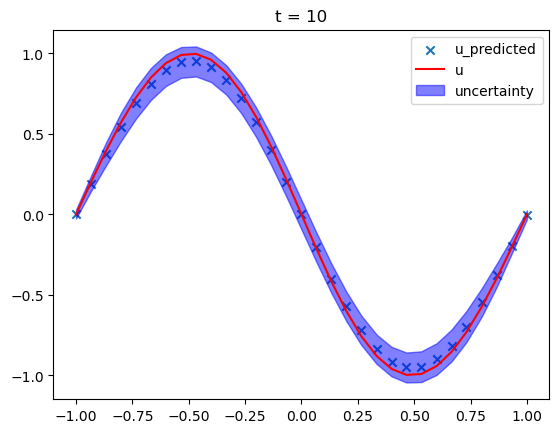

Time step 11 is done. Time taken: 0.6978950500488281
Time step 12 is done. Time taken: 0.6862010955810547
Time step 13 is done. Time taken: 0.6948351860046387
Time step 14 is done. Time taken: 0.6862380504608154
Time step 15 is done. Time taken: 0.6713459491729736
Time step 16 is done. Time taken: 0.6761510372161865
Time step 17 is done. Time taken: 0.6786978244781494
Time step 18 is done. Time taken: 0.6752798557281494
Time step 19 is done. Time taken: 0.7479619979858398
Time step 20 is done. Time taken: 0.6882879734039307


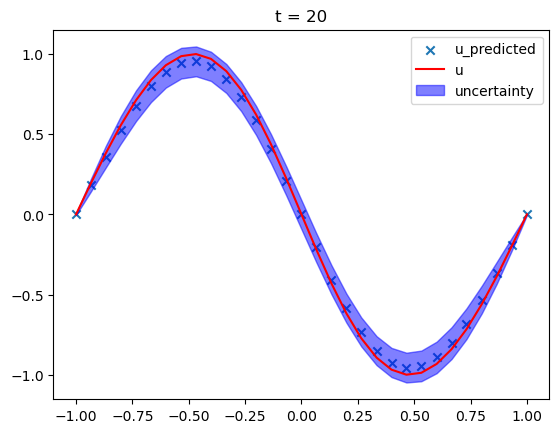

Time step 21 is done. Time taken: 0.6963741779327393
Time step 22 is done. Time taken: 0.676516056060791
Time step 23 is done. Time taken: 0.6742808818817139
Time step 24 is done. Time taken: 0.6796369552612305
Time step 25 is done. Time taken: 0.6861538887023926
Time step 26 is done. Time taken: 0.6793098449707031
Time step 27 is done. Time taken: 0.6826319694519043
Time step 28 is done. Time taken: 0.6859526634216309
Time step 29 is done. Time taken: 0.6810610294342041
Time step 30 is done. Time taken: 0.6892242431640625


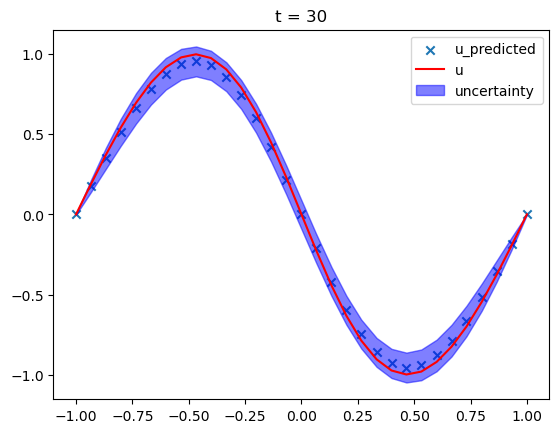

Time step 31 is done. Time taken: 0.7592902183532715
Time step 32 is done. Time taken: 0.6828889846801758
Time step 33 is done. Time taken: 0.6793568134307861
Time step 34 is done. Time taken: 0.6856472492218018
Time step 35 is done. Time taken: 0.6777892112731934
Time step 36 is done. Time taken: 1.3421630859375
Time step 37 is done. Time taken: 0.674746036529541
Time step 38 is done. Time taken: 0.6701722145080566
Time step 39 is done. Time taken: 0.7152941226959229
Time step 40 is done. Time taken: 0.6705918312072754


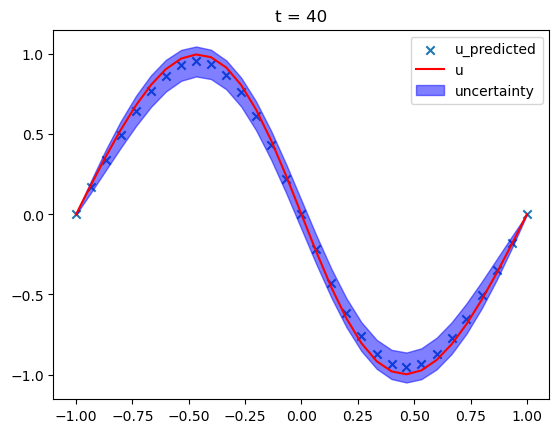

Time step 41 is done. Time taken: 0.6930429935455322
Time step 42 is done. Time taken: 0.6736099720001221
Time step 43 is done. Time taken: 0.6783769130706787
Time step 44 is done. Time taken: 0.6798219680786133
Time step 45 is done. Time taken: 0.6784818172454834
Time step 46 is done. Time taken: 0.6796879768371582
Time step 47 is done. Time taken: 0.675602912902832
Time step 48 is done. Time taken: 0.674522876739502
Time step 49 is done. Time taken: 0.6837067604064941
Time step 50 is done. Time taken: 0.671004056930542


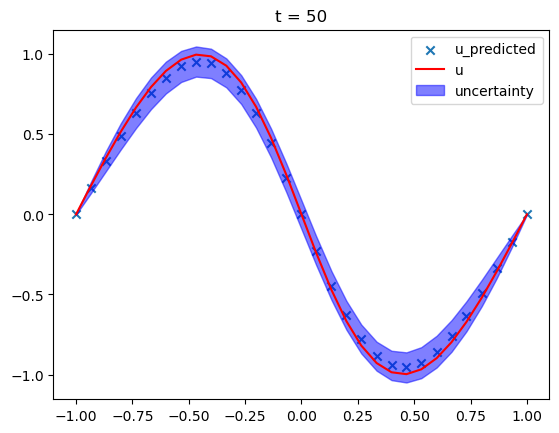

Time step 51 is done. Time taken: 0.6883437633514404
Time step 52 is done. Time taken: 0.6836109161376953
Time step 53 is done. Time taken: 0.6807889938354492
Time step 54 is done. Time taken: 0.6889159679412842
Time step 55 is done. Time taken: 0.6668329238891602
Time step 56 is done. Time taken: 0.690338134765625
Time step 57 is done. Time taken: 0.7080960273742676
Time step 58 is done. Time taken: 0.6934561729431152
Time step 59 is done. Time taken: 0.6852009296417236
Time step 60 is done. Time taken: 0.6848969459533691


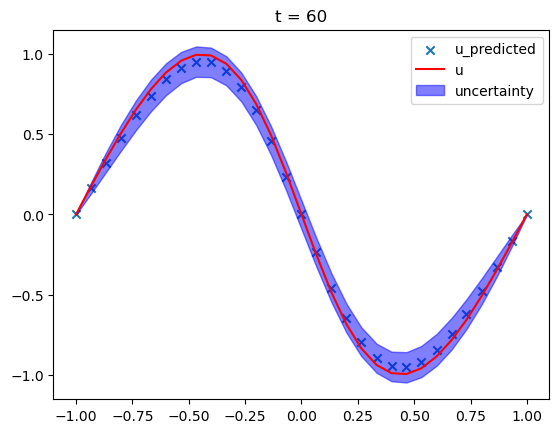

Time step 61 is done. Time taken: 0.69451904296875
Time step 62 is done. Time taken: 0.6776340007781982
Time step 63 is done. Time taken: 0.6717817783355713
Time step 64 is done. Time taken: 0.6779699325561523
Time step 65 is done. Time taken: 0.6736369132995605
Time step 66 is done. Time taken: 0.6863641738891602
Time step 67 is done. Time taken: 0.6683769226074219
Time step 68 is done. Time taken: 0.6933639049530029
Time step 69 is done. Time taken: 0.6746940612792969
Time step 70 is done. Time taken: 0.6814680099487305


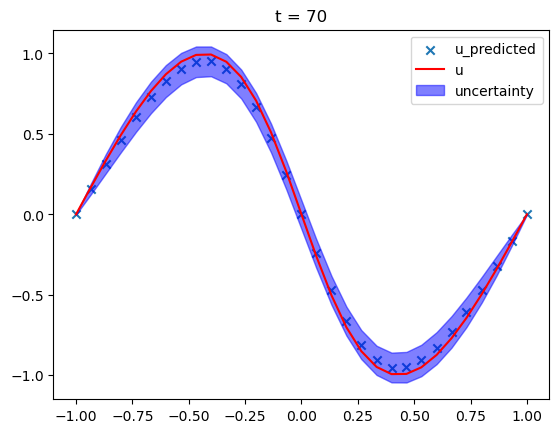

Time step 71 is done. Time taken: 0.6934058666229248
Time step 72 is done. Time taken: 0.7075638771057129
Time step 73 is done. Time taken: 0.67867112159729
Time step 74 is done. Time taken: 0.6760768890380859
Time step 75 is done. Time taken: 0.6766262054443359
Time step 76 is done. Time taken: 0.6867718696594238
Time step 77 is done. Time taken: 0.7571258544921875
Time step 78 is done. Time taken: 0.7742547988891602
Time step 79 is done. Time taken: 0.678905725479126
Time step 80 is done. Time taken: 0.6760878562927246


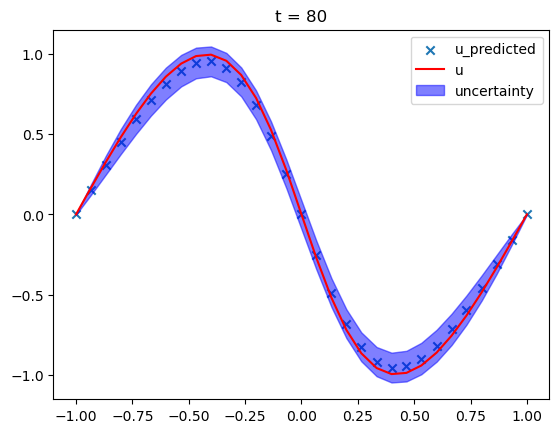

Time step 81 is done. Time taken: 0.7113840579986572
Time step 82 is done. Time taken: 0.6822788715362549
Time step 83 is done. Time taken: 0.681337833404541
Time step 84 is done. Time taken: 0.6919050216674805
Time step 85 is done. Time taken: 0.6733498573303223
Time step 86 is done. Time taken: 0.6708378791809082
Time step 87 is done. Time taken: 0.6789407730102539
Time step 88 is done. Time taken: 0.6780657768249512
Time step 89 is done. Time taken: 0.6753170490264893
Time step 90 is done. Time taken: 0.673774003982544


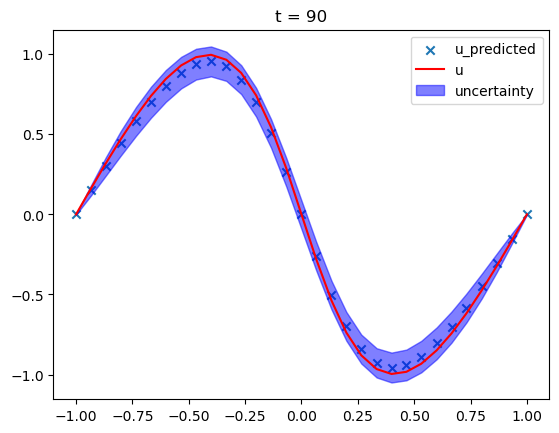

Time step 91 is done. Time taken: 0.6938350200653076
Time step 92 is done. Time taken: 0.7427148818969727
Time step 93 is done. Time taken: 0.6887331008911133
Time step 94 is done. Time taken: 0.677778959274292
Time step 95 is done. Time taken: 0.6802401542663574
Time step 96 is done. Time taken: 0.6724112033843994
Time step 97 is done. Time taken: 0.6732418537139893
Time step 98 is done. Time taken: 0.6696698665618896
Time step 99 is done. Time taken: 0.6735191345214844
Time step 100 is done. Time taken: 0.676062822341919


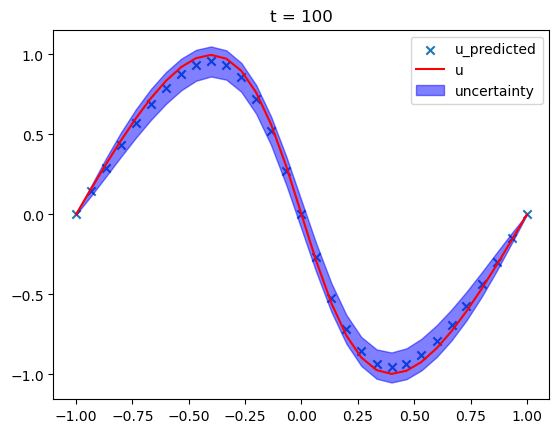

Time step 101 is done. Time taken: 0.6938722133636475
Time step 102 is done. Time taken: 0.6749799251556396
Time step 103 is done. Time taken: 0.6791350841522217
Time step 104 is done. Time taken: 0.6811277866363525
Time step 105 is done. Time taken: 0.6732668876647949
Time step 106 is done. Time taken: 0.6720221042633057
Time step 107 is done. Time taken: 0.6720519065856934
Time step 108 is done. Time taken: 0.7255568504333496
Time step 109 is done. Time taken: 0.6719443798065186
Time step 110 is done. Time taken: 0.6727762222290039


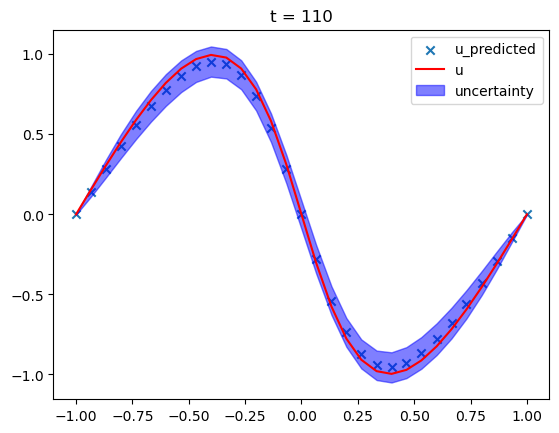

Time step 111 is done. Time taken: 0.6911969184875488
Time step 112 is done. Time taken: 0.6709890365600586
Time step 113 is done. Time taken: 0.6703441143035889
Time step 114 is done. Time taken: 0.7132008075714111
Time step 115 is done. Time taken: 0.6736159324645996
Time step 116 is done. Time taken: 0.6726632118225098
Time step 117 is done. Time taken: 0.6682791709899902
Time step 118 is done. Time taken: 0.6771132946014404
Time step 119 is done. Time taken: 0.6765720844268799
Time step 120 is done. Time taken: 0.6829619407653809


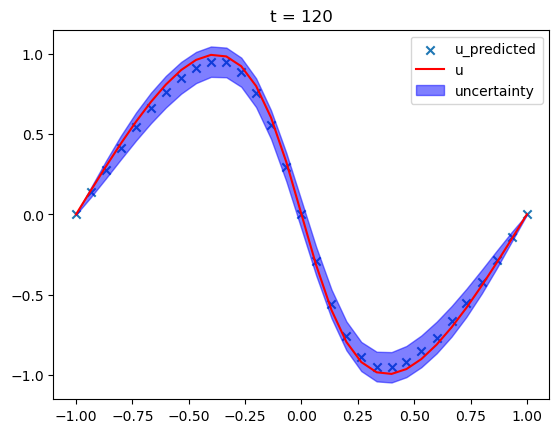

Time step 121 is done. Time taken: 0.6869397163391113
Time step 122 is done. Time taken: 0.6713690757751465
Time step 123 is done. Time taken: 0.6751091480255127
Time step 124 is done. Time taken: 0.6713719367980957
Time step 125 is done. Time taken: 0.6684830188751221
Time step 126 is done. Time taken: 0.6744377613067627
Time step 127 is done. Time taken: 0.6802899837493896
Time step 128 is done. Time taken: 0.770787239074707
Time step 129 is done. Time taken: 0.9542930126190186
Time step 130 is done. Time taken: 0.745466947555542


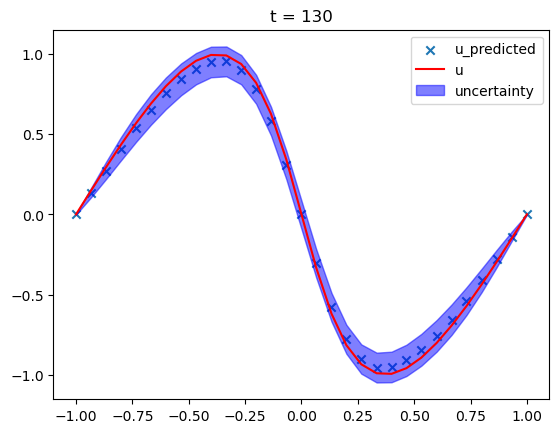

Time step 131 is done. Time taken: 0.7415697574615479
Time step 132 is done. Time taken: 0.6967239379882812
Time step 133 is done. Time taken: 1.6578700542449951
Time step 134 is done. Time taken: 0.7267940044403076
Time step 135 is done. Time taken: 0.8277328014373779
Time step 136 is done. Time taken: 0.7018110752105713
Time step 137 is done. Time taken: 0.7036149501800537
Time step 138 is done. Time taken: 0.7948915958404541
Time step 139 is done. Time taken: 0.7008287906646729
Time step 140 is done. Time taken: 0.6782410144805908


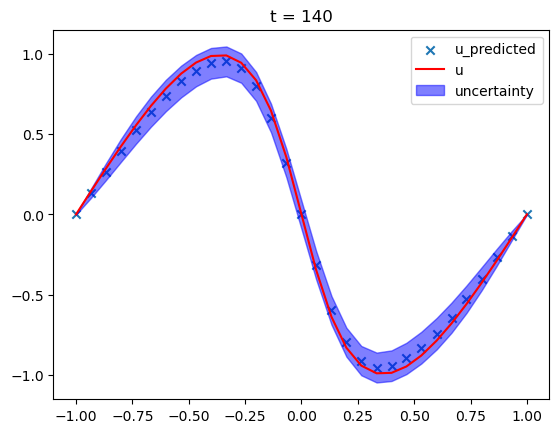

Time step 141 is done. Time taken: 0.6840720176696777
Time step 142 is done. Time taken: 0.7144379615783691
Time step 143 is done. Time taken: 0.6698620319366455
Time step 144 is done. Time taken: 0.6763327121734619
Time step 145 is done. Time taken: 0.6940600872039795
Time step 146 is done. Time taken: 0.6822216510772705
Time step 147 is done. Time taken: 0.6758320331573486
Time step 148 is done. Time taken: 0.7540421485900879
Time step 149 is done. Time taken: 0.7879900932312012
Time step 150 is done. Time taken: 0.6914370059967041


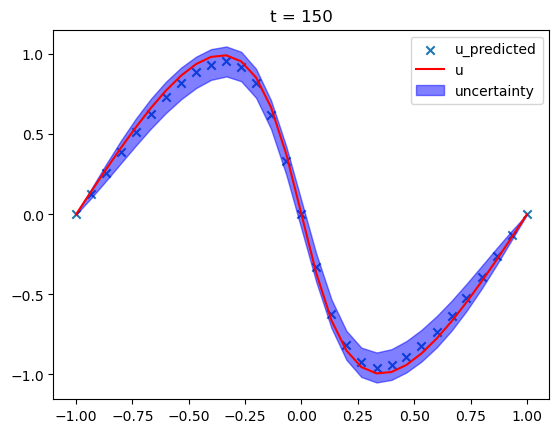

Time step 151 is done. Time taken: 0.7305059432983398
Time step 152 is done. Time taken: 0.7247898578643799
Time step 153 is done. Time taken: 0.7047629356384277
Time step 154 is done. Time taken: 0.852715015411377
Time step 155 is done. Time taken: 0.6924188137054443
Time step 156 is done. Time taken: 0.668773889541626
Time step 157 is done. Time taken: 0.6966021060943604
Time step 158 is done. Time taken: 0.6824719905853271
Time step 159 is done. Time taken: 0.6907351016998291
Time step 160 is done. Time taken: 0.6641290187835693


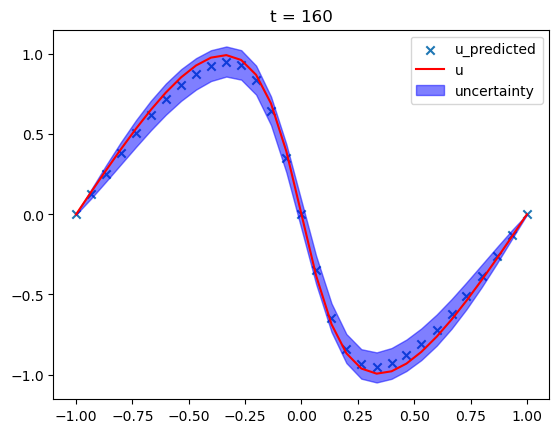

Time step 161 is done. Time taken: 0.6707360744476318
Time step 162 is done. Time taken: 0.6554269790649414
Time step 163 is done. Time taken: 0.6509089469909668
Time step 164 is done. Time taken: 0.6595509052276611
Time step 165 is done. Time taken: 0.6538119316101074
Time step 166 is done. Time taken: 0.6757688522338867
Time step 167 is done. Time taken: 0.6731650829315186
Time step 168 is done. Time taken: 0.7639989852905273
Time step 169 is done. Time taken: 0.753760814666748
Time step 170 is done. Time taken: 0.6810760498046875


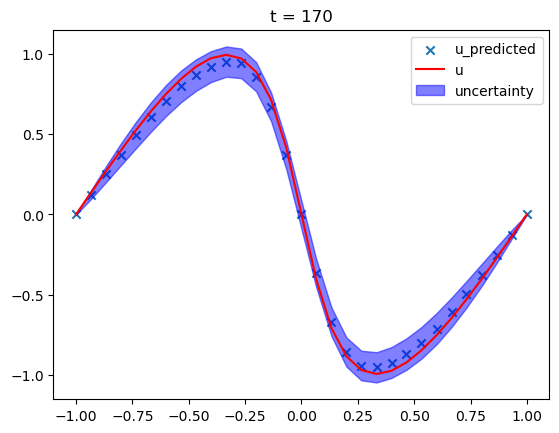

Time step 171 is done. Time taken: 0.7001872062683105
Time step 172 is done. Time taken: 0.6778810024261475
Time step 173 is done. Time taken: 0.6742088794708252
Time step 174 is done. Time taken: 0.6572937965393066
Time step 175 is done. Time taken: 0.6570169925689697
Time step 176 is done. Time taken: 0.6518700122833252
Time step 177 is done. Time taken: 0.6506810188293457
Time step 178 is done. Time taken: 0.650360107421875
Time step 179 is done. Time taken: 0.6609978675842285
Time step 180 is done. Time taken: 0.6539850234985352


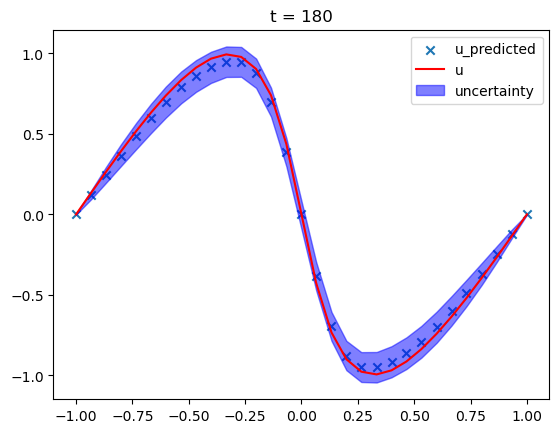

Time step 181 is done. Time taken: 0.6657519340515137
Time step 182 is done. Time taken: 0.660567045211792
Time step 183 is done. Time taken: 0.6522431373596191
Time step 184 is done. Time taken: 0.6524820327758789
Time step 185 is done. Time taken: 0.6510961055755615
Time step 186 is done. Time taken: 0.6656477451324463
Time step 187 is done. Time taken: 0.6768758296966553
Time step 188 is done. Time taken: 0.6817300319671631
Time step 189 is done. Time taken: 0.6940741539001465
Time step 190 is done. Time taken: 0.7088198661804199


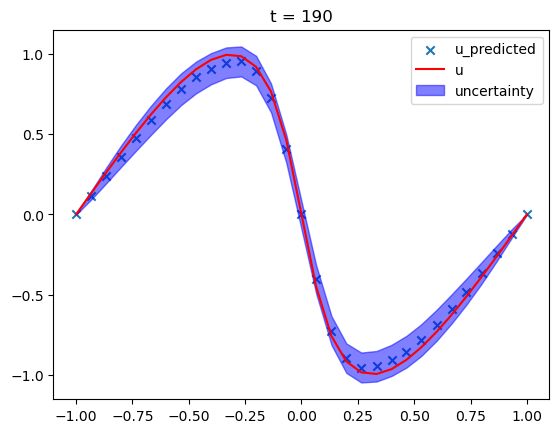

Time step 191 is done. Time taken: 0.7071051597595215
Time step 192 is done. Time taken: 1.7813310623168945
Time step 193 is done. Time taken: 0.688899040222168
Time step 194 is done. Time taken: 0.6540799140930176
Time step 195 is done. Time taken: 0.6524078845977783
Time step 196 is done. Time taken: 0.6565518379211426
Time step 197 is done. Time taken: 0.6503880023956299
Time step 198 is done. Time taken: 0.6609768867492676
Time step 199 is done. Time taken: 0.6905567646026611
Time step 200 is done. Time taken: 0.7242898941040039


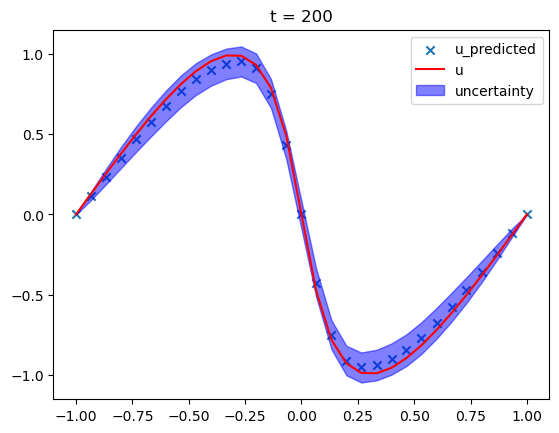

Time step 201 is done. Time taken: 0.794950008392334
Time step 202 is done. Time taken: 0.6788921356201172
Time step 203 is done. Time taken: 0.6835470199584961
Time step 204 is done. Time taken: 0.6679949760437012
Time step 205 is done. Time taken: 0.7188460826873779
Time step 206 is done. Time taken: 0.7187919616699219
Time step 207 is done. Time taken: 0.6773920059204102
Time step 208 is done. Time taken: 0.9316999912261963
Time step 209 is done. Time taken: 0.8106679916381836
Time step 210 is done. Time taken: 0.7870018482208252


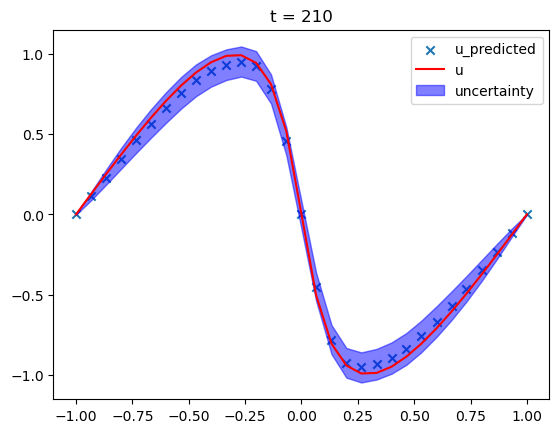

Time step 211 is done. Time taken: 0.791395902633667
Time step 212 is done. Time taken: 0.735741138458252
Time step 213 is done. Time taken: 0.7109878063201904
Time step 214 is done. Time taken: 0.7320270538330078
Time step 215 is done. Time taken: 0.7825069427490234
Time step 216 is done. Time taken: 0.7068557739257812
Time step 217 is done. Time taken: 0.7887732982635498
Time step 218 is done. Time taken: 0.6905860900878906
Time step 219 is done. Time taken: 0.6954817771911621
Time step 220 is done. Time taken: 0.697613000869751


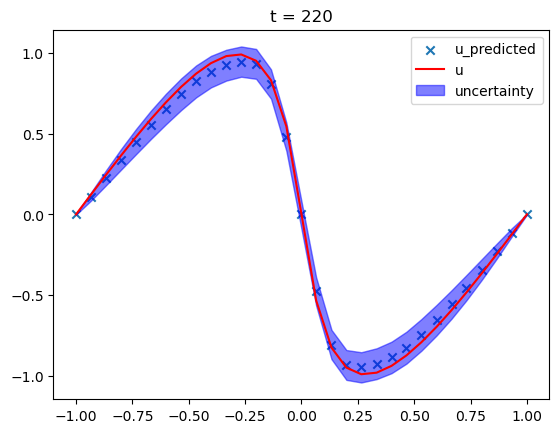

Time step 221 is done. Time taken: 0.695573091506958
Time step 222 is done. Time taken: 0.6768839359283447
Time step 223 is done. Time taken: 0.6807889938354492
Time step 224 is done. Time taken: 0.6803689002990723
Time step 225 is done. Time taken: 0.673828125
Time step 226 is done. Time taken: 0.6696410179138184
Time step 227 is done. Time taken: 0.6771128177642822
Time step 228 is done. Time taken: 0.6768920421600342
Time step 229 is done. Time taken: 0.6925079822540283
Time step 230 is done. Time taken: 0.7750809192657471


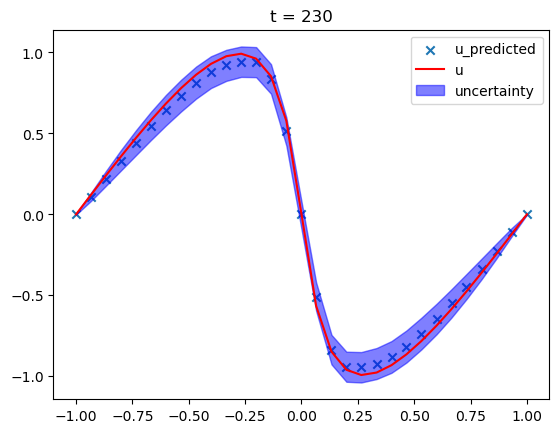

Time step 231 is done. Time taken: 0.7479538917541504
Time step 232 is done. Time taken: 0.7054798603057861
Time step 233 is done. Time taken: 0.7266700267791748
Time step 234 is done. Time taken: 0.8166520595550537
Time step 235 is done. Time taken: 0.7247829437255859
Time step 236 is done. Time taken: 0.7196989059448242
Time step 237 is done. Time taken: 0.6840488910675049
Time step 238 is done. Time taken: 0.7146391868591309
Time step 239 is done. Time taken: 0.6978061199188232
Time step 240 is done. Time taken: 0.6856448650360107


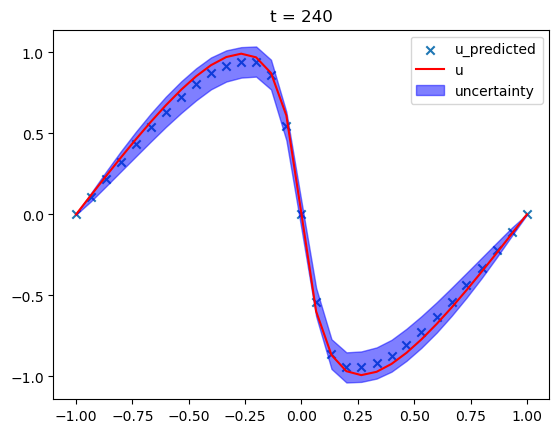

Time step 241 is done. Time taken: 0.7241809368133545
Time step 242 is done. Time taken: 0.7037708759307861
Time step 243 is done. Time taken: 0.7796380519866943
Time step 244 is done. Time taken: 0.7468082904815674
Time step 245 is done. Time taken: 0.6904070377349854
Time step 246 is done. Time taken: 0.7838931083679199
Time step 247 is done. Time taken: 0.7342560291290283
Time step 248 is done. Time taken: 0.7259950637817383
Time step 249 is done. Time taken: 0.770820140838623
Time step 250 is done. Time taken: 0.7062332630157471


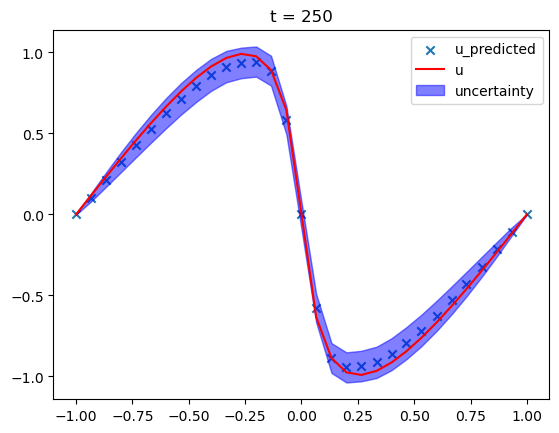

Time step 251 is done. Time taken: 0.6833767890930176
Time step 252 is done. Time taken: 0.6638250350952148
Time step 253 is done. Time taken: 0.7827908992767334
Time step 254 is done. Time taken: 0.6830029487609863
Time step 255 is done. Time taken: 0.6752610206604004
Time step 256 is done. Time taken: 0.6735141277313232
Time step 257 is done. Time taken: 2.1477651596069336
Time step 258 is done. Time taken: 0.7449488639831543
Time step 259 is done. Time taken: 0.7711586952209473
Time step 260 is done. Time taken: 0.6654329299926758


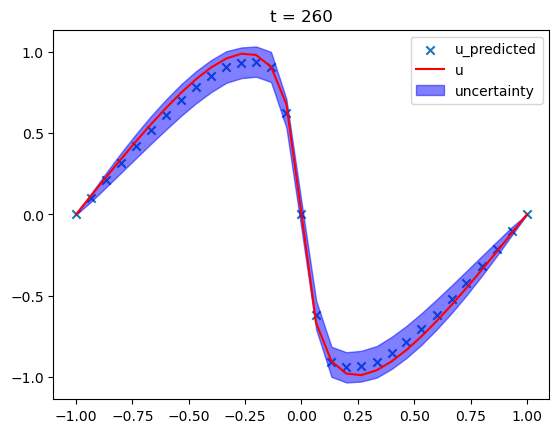

Time step 261 is done. Time taken: 0.7273359298706055
Time step 262 is done. Time taken: 0.7281761169433594
Time step 263 is done. Time taken: 0.6844878196716309
Time step 264 is done. Time taken: 0.6744379997253418
Time step 265 is done. Time taken: 0.6619842052459717
Time step 266 is done. Time taken: 0.6598658561706543
Time step 267 is done. Time taken: 0.7045931816101074
Time step 268 is done. Time taken: 0.6724779605865479
Time step 269 is done. Time taken: 0.7083969116210938
Time step 270 is done. Time taken: 0.7132470607757568


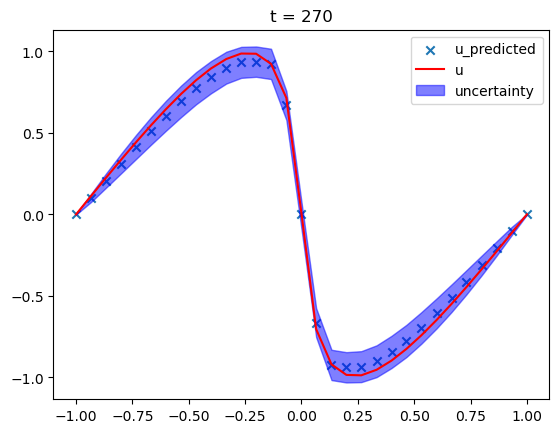

Time step 271 is done. Time taken: 0.7331728935241699
Time step 272 is done. Time taken: 0.8459439277648926
Time step 273 is done. Time taken: 0.7062911987304688
Time step 274 is done. Time taken: 0.7142770290374756
Time step 275 is done. Time taken: 0.7585170269012451
Time step 276 is done. Time taken: 0.7195987701416016
Time step 277 is done. Time taken: 0.6883430480957031
Time step 278 is done. Time taken: 0.7408289909362793
Time step 279 is done. Time taken: 0.7135891914367676
Time step 280 is done. Time taken: 0.7018649578094482


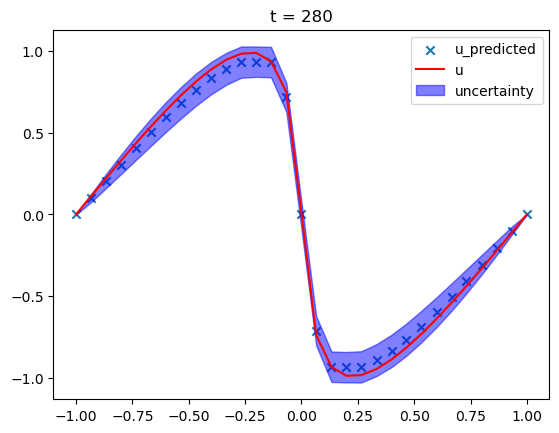

Time step 281 is done. Time taken: 0.7742409706115723
Time step 282 is done. Time taken: 0.7130811214447021
Time step 283 is done. Time taken: 0.7158019542694092
Time step 284 is done. Time taken: 0.6908280849456787
Time step 285 is done. Time taken: 0.7012820243835449
Time step 286 is done. Time taken: 0.7298920154571533
Time step 287 is done. Time taken: 0.7564878463745117
Time step 288 is done. Time taken: 0.7124271392822266
Time step 289 is done. Time taken: 0.6921522617340088
Time step 290 is done. Time taken: 0.7776610851287842


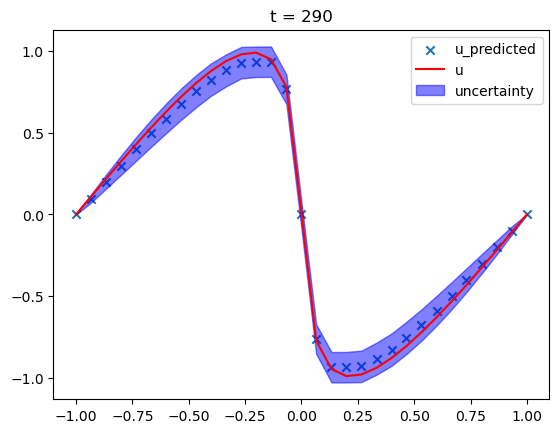

Time step 291 is done. Time taken: 0.7218680381774902
Time step 292 is done. Time taken: 0.7076258659362793
Time step 293 is done. Time taken: 0.6776831150054932
Time step 294 is done. Time taken: 0.8573858737945557
Time step 295 is done. Time taken: 0.7801060676574707
Time step 296 is done. Time taken: 0.7223391532897949
Time step 297 is done. Time taken: 0.7701907157897949
Time step 298 is done. Time taken: 0.7139022350311279
Time step 299 is done. Time taken: 0.7149960994720459
Time step 300 is done. Time taken: 0.7112560272216797


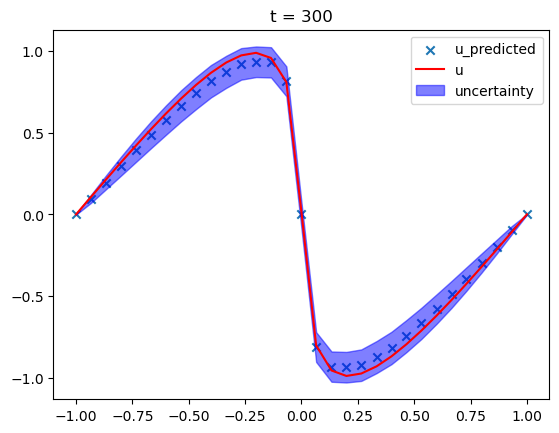

Time step 301 is done. Time taken: 0.8193740844726562
Time step 302 is done. Time taken: 0.7612192630767822
Time step 303 is done. Time taken: 0.7023971080780029
Time step 304 is done. Time taken: 0.7042701244354248
Time step 305 is done. Time taken: 0.7388150691986084
Time step 306 is done. Time taken: 0.7107639312744141
Time step 307 is done. Time taken: 0.686255931854248
Time step 308 is done. Time taken: 0.6682448387145996
Time step 309 is done. Time taken: 0.6606380939483643
Time step 310 is done. Time taken: 0.6597087383270264


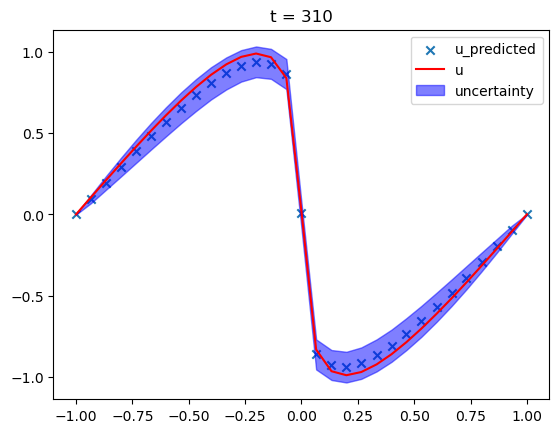

Time step 311 is done. Time taken: 0.6818461418151855
Time step 312 is done. Time taken: 0.696613073348999
Time step 313 is done. Time taken: 0.7421178817749023
Time step 314 is done. Time taken: 0.66379714012146
Time step 315 is done. Time taken: 0.6536388397216797
Time step 316 is done. Time taken: 0.6560378074645996
Time step 317 is done. Time taken: 0.6754868030548096
Time step 318 is done. Time taken: 0.6530859470367432
Time step 319 is done. Time taken: 0.691274881362915
Time step 320 is done. Time taken: 0.663567066192627


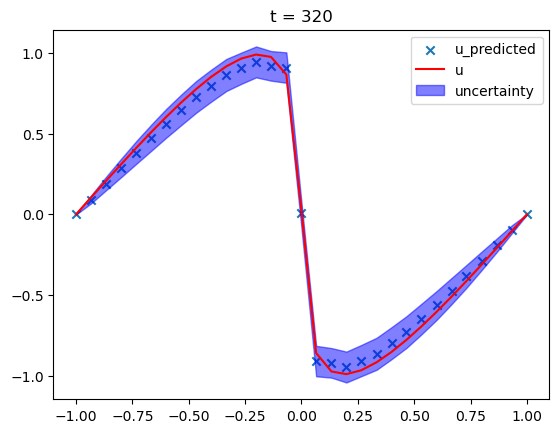

Time step 321 is done. Time taken: 0.6792628765106201
Time step 322 is done. Time taken: 0.6610491275787354
Time step 323 is done. Time taken: 0.6614589691162109
Time step 324 is done. Time taken: 0.6590840816497803
Time step 325 is done. Time taken: 0.6571331024169922
Time step 326 is done. Time taken: 0.67824387550354
Time step 327 is done. Time taken: 0.6648678779602051
Time step 328 is done. Time taken: 0.6597139835357666
Time step 329 is done. Time taken: 2.3890411853790283
Time step 330 is done. Time taken: 0.693950891494751


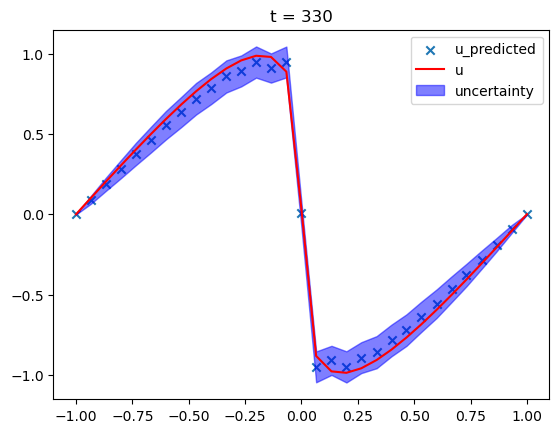

Time step 331 is done. Time taken: 0.6771471500396729
Time step 332 is done. Time taken: 0.6571788787841797
Time step 333 is done. Time taken: 0.6547329425811768
Time step 334 is done. Time taken: 0.6589958667755127
Time step 335 is done. Time taken: 0.6531047821044922
Time step 336 is done. Time taken: 0.6583466529846191
Time step 337 is done. Time taken: 0.660484790802002
Time step 338 is done. Time taken: 0.6533408164978027
Time step 339 is done. Time taken: 0.6622910499572754
Time step 340 is done. Time taken: 0.6619529724121094


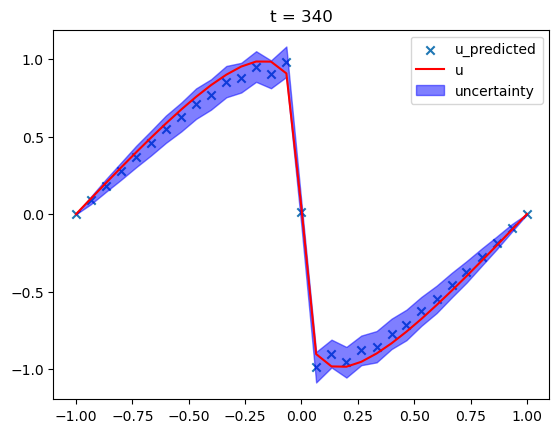

Time step 341 is done. Time taken: 0.6685161590576172
Time step 342 is done. Time taken: 0.6624460220336914
Time step 343 is done. Time taken: 0.6527419090270996
Time step 344 is done. Time taken: 0.6566798686981201
Time step 345 is done. Time taken: 0.6555790901184082
Time step 346 is done. Time taken: 0.655750036239624
Time step 347 is done. Time taken: 0.6566829681396484
Time step 348 is done. Time taken: 0.6596379280090332
Time step 349 is done. Time taken: 0.6804718971252441
Time step 350 is done. Time taken: 0.6692109107971191


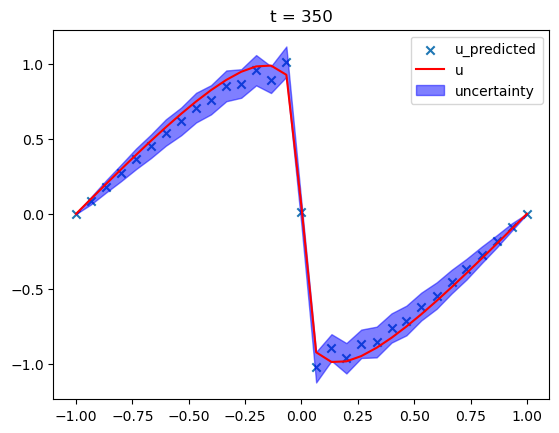

Time step 351 is done. Time taken: 0.6725189685821533
Time step 352 is done. Time taken: 0.6568808555603027
Time step 353 is done. Time taken: 0.6576929092407227
Time step 354 is done. Time taken: 0.6600320339202881
Time step 355 is done. Time taken: 0.6550798416137695
Time step 356 is done. Time taken: 0.661419153213501
Time step 357 is done. Time taken: 0.660952091217041
Time step 358 is done. Time taken: 0.6626639366149902
Time step 359 is done. Time taken: 0.6528370380401611
Time step 360 is done. Time taken: 0.7304279804229736


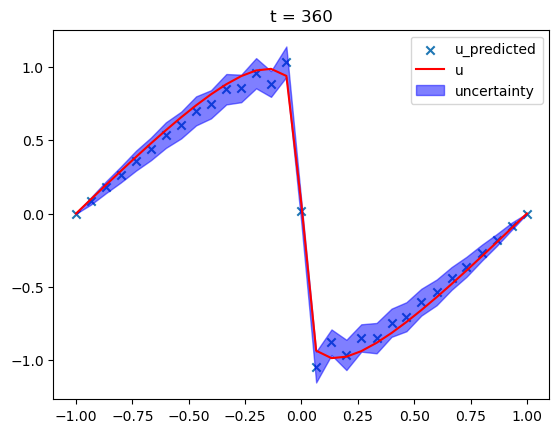

Time step 361 is done. Time taken: 0.6754271984100342
Time step 362 is done. Time taken: 0.6622910499572754
Time step 363 is done. Time taken: 0.6553759574890137
Time step 364 is done. Time taken: 0.654545783996582
Time step 365 is done. Time taken: 0.6577768325805664
Time step 366 is done. Time taken: 0.6527369022369385
Time step 367 is done. Time taken: 0.655081033706665
Time step 368 is done. Time taken: 0.6541061401367188
Time step 369 is done. Time taken: 0.6593260765075684
Time step 370 is done. Time taken: 0.65653395652771


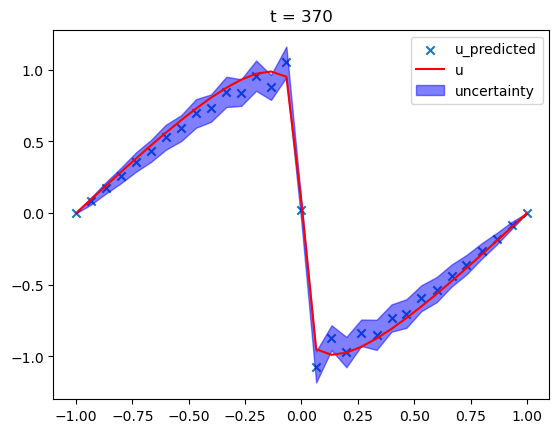

Time step 371 is done. Time taken: 0.6729538440704346
Time step 372 is done. Time taken: 0.6558048725128174
Time step 373 is done. Time taken: 0.657768964767456
Time step 374 is done. Time taken: 0.6639819145202637
Time step 375 is done. Time taken: 0.6558272838592529
Time step 376 is done. Time taken: 0.6692831516265869
Time step 377 is done. Time taken: 0.6573009490966797
Time step 378 is done. Time taken: 0.652263879776001
Time step 379 is done. Time taken: 0.6558053493499756
Time step 380 is done. Time taken: 0.6530389785766602


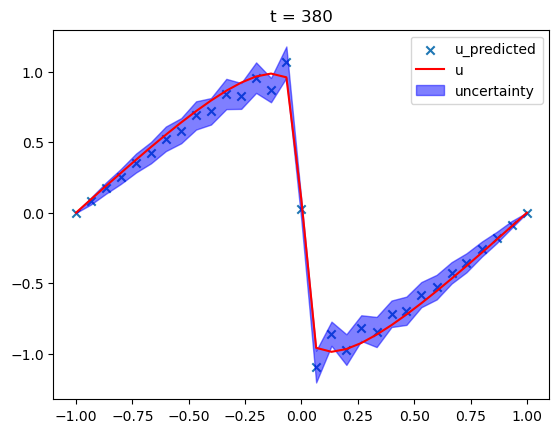

Time step 381 is done. Time taken: 0.6746218204498291
Time step 382 is done. Time taken: 0.6688776016235352
Time step 383 is done. Time taken: 0.6552581787109375
Time step 384 is done. Time taken: 0.6532821655273438
Time step 385 is done. Time taken: 0.6698830127716064
Time step 386 is done. Time taken: 0.653660774230957
Time step 387 is done. Time taken: 0.6588699817657471
Time step 388 is done. Time taken: 0.658358097076416
Time step 389 is done. Time taken: 0.6557681560516357
Time step 390 is done. Time taken: 0.7434313297271729


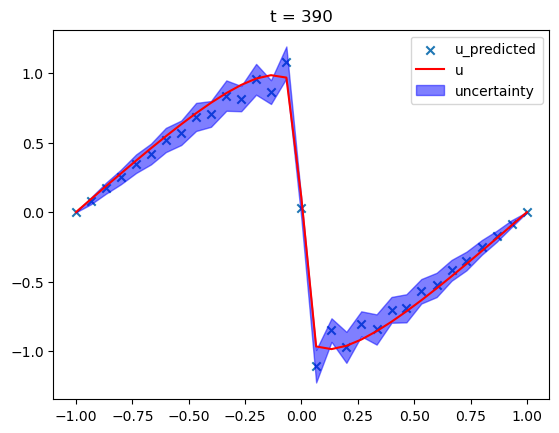

Time step 391 is done. Time taken: 0.6786739826202393
Time step 392 is done. Time taken: 0.6913001537322998
Time step 393 is done. Time taken: 0.6645450592041016
Time step 394 is done. Time taken: 0.6513209342956543
Time step 395 is done. Time taken: 0.6654551029205322
Time step 396 is done. Time taken: 0.6634130477905273
Time step 397 is done. Time taken: 0.6640031337738037
Time step 398 is done. Time taken: 0.6948850154876709
Time step 399 is done. Time taken: 0.6758079528808594
Time step 400 is done. Time taken: 0.6909401416778564


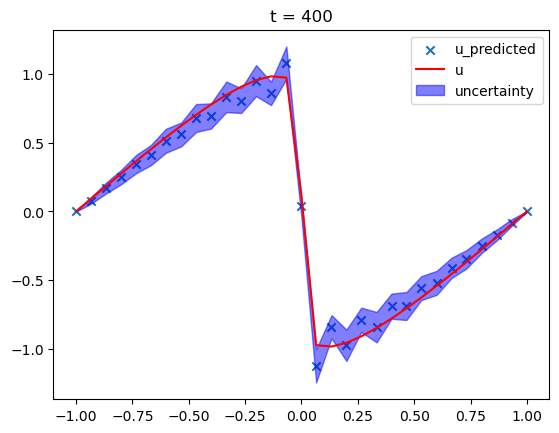

Time step 401 is done. Time taken: 0.7191081047058105
Time step 402 is done. Time taken: 0.8660433292388916
Time step 403 is done. Time taken: 0.7368083000183105
Time step 404 is done. Time taken: 0.7053756713867188
Time step 405 is done. Time taken: 0.7857749462127686
Time step 406 is done. Time taken: 0.7095780372619629
Time step 407 is done. Time taken: 0.6878201961517334
Time step 408 is done. Time taken: 0.6829259395599365
Time step 409 is done. Time taken: 0.8734328746795654
Time step 410 is done. Time taken: 0.8306796550750732


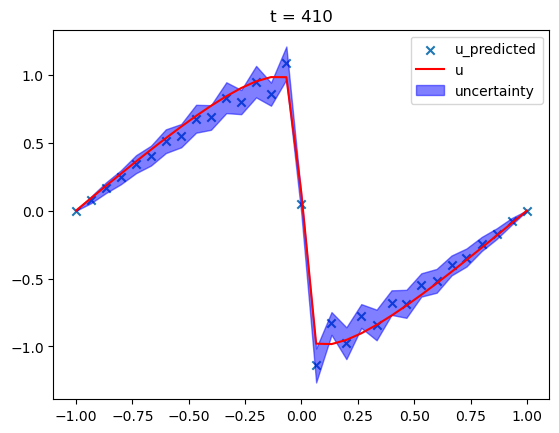

Time step 411 is done. Time taken: 3.279109001159668
Time step 412 is done. Time taken: 0.6859850883483887
Time step 413 is done. Time taken: 0.6736109256744385
Time step 414 is done. Time taken: 0.7331173419952393
Time step 415 is done. Time taken: 0.6578121185302734
Time step 416 is done. Time taken: 0.6513757705688477
Time step 417 is done. Time taken: 0.651320219039917
Time step 418 is done. Time taken: 0.6538872718811035
Time step 419 is done. Time taken: 0.6529269218444824
Time step 420 is done. Time taken: 0.6547768115997314


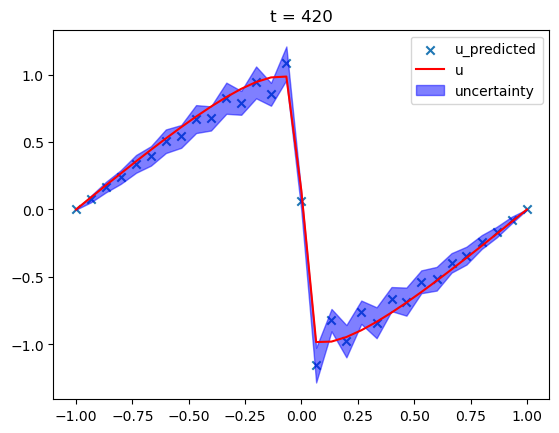

Time step 421 is done. Time taken: 0.6714837551116943
Time step 422 is done. Time taken: 0.6560120582580566
Time step 423 is done. Time taken: 0.6511020660400391
Time step 424 is done. Time taken: 0.6655600070953369
Time step 425 is done. Time taken: 0.6529991626739502
Time step 426 is done. Time taken: 0.6571168899536133
Time step 427 is done. Time taken: 0.6549301147460938
Time step 428 is done. Time taken: 0.6535952091217041
Time step 429 is done. Time taken: 0.6553149223327637
Time step 430 is done. Time taken: 0.6579320430755615


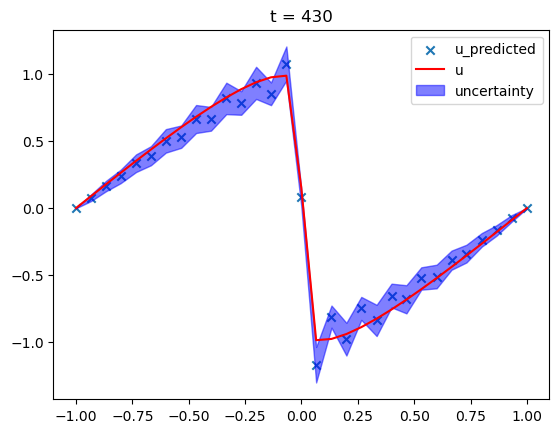

Time step 431 is done. Time taken: 0.6717541217803955
Time step 432 is done. Time taken: 0.6594569683074951
Time step 433 is done. Time taken: 0.6559109687805176
Time step 434 is done. Time taken: 0.7125658988952637
Time step 435 is done. Time taken: 0.6523919105529785
Time step 436 is done. Time taken: 0.7352042198181152
Time step 437 is done. Time taken: 0.652390718460083
Time step 438 is done. Time taken: 0.6650300025939941
Time step 439 is done. Time taken: 0.6589682102203369
Time step 440 is done. Time taken: 0.6967160701751709


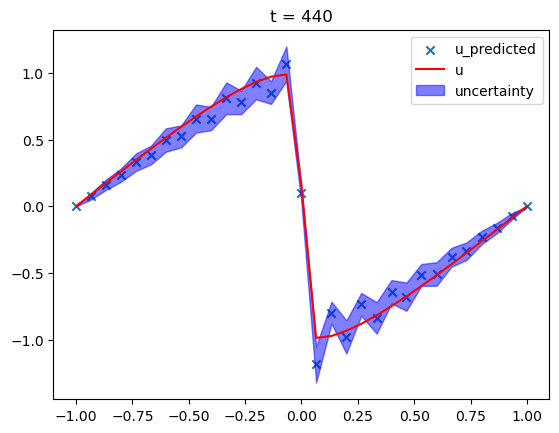

Time step 441 is done. Time taken: 0.6783270835876465
Time step 442 is done. Time taken: 0.6612279415130615
Time step 443 is done. Time taken: 0.6583619117736816
Time step 444 is done. Time taken: 0.6556291580200195
Time step 445 is done. Time taken: 0.655540943145752
Time step 446 is done. Time taken: 0.6682779788970947
Time step 447 is done. Time taken: 0.6520371437072754
Time step 448 is done. Time taken: 0.6503100395202637
Time step 449 is done. Time taken: 0.6681277751922607
Time step 450 is done. Time taken: 0.659038782119751


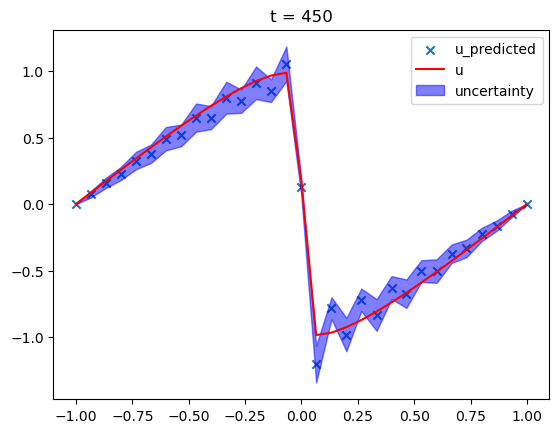

Time step 451 is done. Time taken: 0.6717021465301514
Time step 452 is done. Time taken: 0.6565628051757812
Time step 453 is done. Time taken: 0.6542360782623291
Time step 454 is done. Time taken: 0.6524708271026611
Time step 455 is done. Time taken: 0.6567440032958984
Time step 456 is done. Time taken: 0.7302939891815186
Time step 457 is done. Time taken: 0.6572790145874023
Time step 458 is done. Time taken: 0.6548159122467041
Time step 459 is done. Time taken: 0.6546807289123535
Time step 460 is done. Time taken: 0.6567080020904541


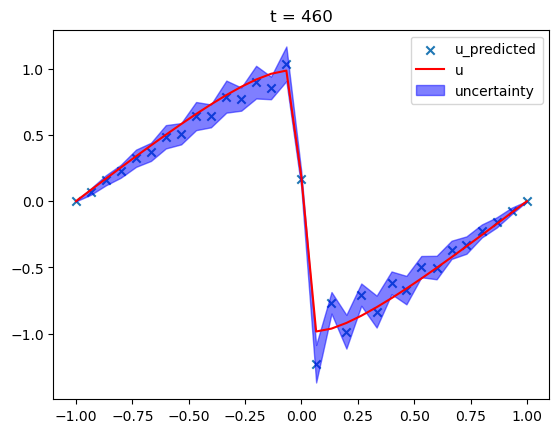

Time step 461 is done. Time taken: 0.6772217750549316
Time step 462 is done. Time taken: 0.6600139141082764
Time step 463 is done. Time taken: 0.6596951484680176
Time step 464 is done. Time taken: 0.6603949069976807
Time step 465 is done. Time taken: 0.6539349555969238
Time step 466 is done. Time taken: 0.681891918182373
Time step 467 is done. Time taken: 0.6631598472595215
Time step 468 is done. Time taken: 0.6498970985412598
Time step 469 is done. Time taken: 0.6545398235321045
Time step 470 is done. Time taken: 0.6545240879058838


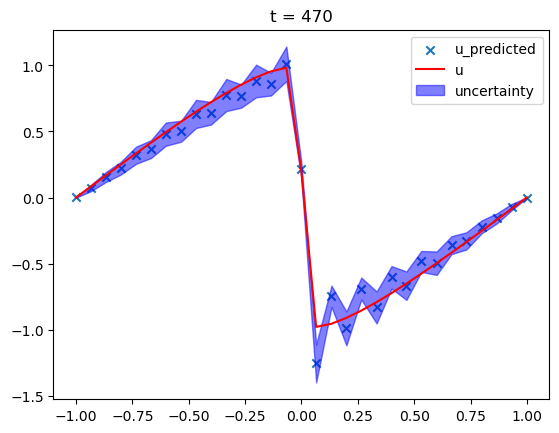

Time step 471 is done. Time taken: 0.6668670177459717
Time step 472 is done. Time taken: 0.7301356792449951
Time step 473 is done. Time taken: 0.655256986618042
Time step 474 is done. Time taken: 0.6542699337005615
Time step 475 is done. Time taken: 0.6542208194732666
Time step 476 is done. Time taken: 0.6640000343322754
Time step 477 is done. Time taken: 0.7016909122467041
Time step 478 is done. Time taken: 0.6752991676330566
Time step 479 is done. Time taken: 0.675440788269043
Time step 480 is done. Time taken: 0.7123270034790039


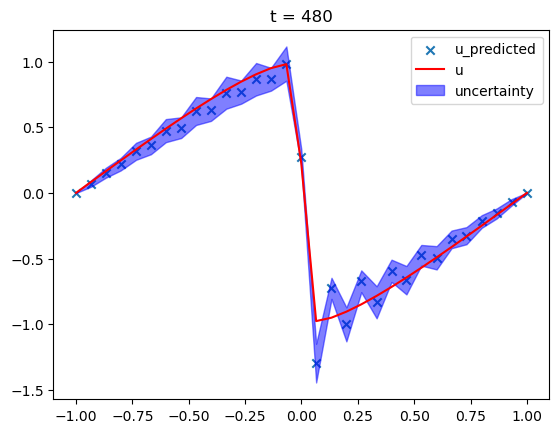

Time step 481 is done. Time taken: 0.692070722579956
Time step 482 is done. Time taken: 0.6578769683837891
Time step 483 is done. Time taken: 0.674903154373169
Time step 484 is done. Time taken: 0.6560380458831787
Time step 485 is done. Time taken: 0.6699090003967285
Time step 486 is done. Time taken: 0.6612429618835449
Time step 487 is done. Time taken: 0.6919839382171631
Time step 488 is done. Time taken: 0.6557440757751465
Time step 489 is done. Time taken: 0.6740579605102539
Time step 490 is done. Time taken: 0.666344165802002


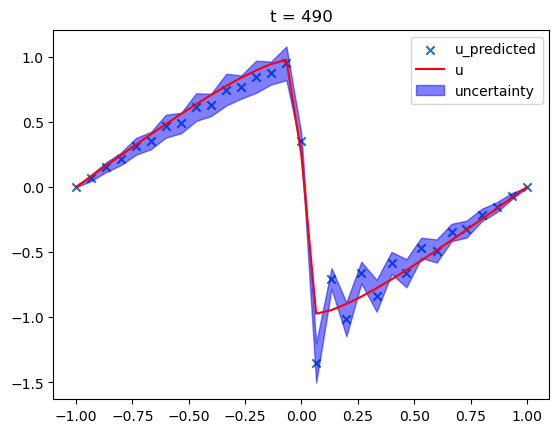

Time step 491 is done. Time taken: 0.674501895904541
Time step 492 is done. Time taken: 0.670698881149292
Time step 493 is done. Time taken: 0.6835958957672119
Time step 494 is done. Time taken: 0.8655471801757812
Time step 495 is done. Time taken: 0.8815228939056396
Time step 496 is done. Time taken: 0.7648923397064209
Time step 497 is done. Time taken: 0.8567788600921631
Time step 498 is done. Time taken: 0.7379148006439209
Time step 499 is done. Time taken: 0.8084297180175781
Time step 500 is done. Time taken: 0.7136781215667725


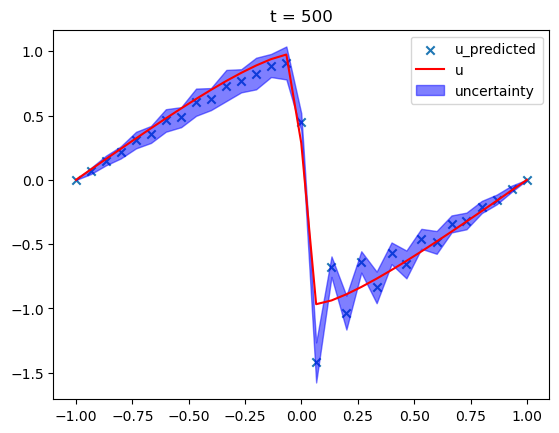

Time step 501 is done. Time taken: 0.7423789501190186
Time step 502 is done. Time taken: 3.893404960632324
Time step 503 is done. Time taken: 0.8027839660644531
Time step 504 is done. Time taken: 0.7079329490661621
Time step 505 is done. Time taken: 0.66861891746521
Time step 506 is done. Time taken: 0.6713998317718506
Time step 507 is done. Time taken: 0.6621417999267578
Time step 508 is done. Time taken: 0.6601951122283936
Time step 509 is done. Time taken: 0.6644139289855957
Time step 510 is done. Time taken: 0.7002551555633545


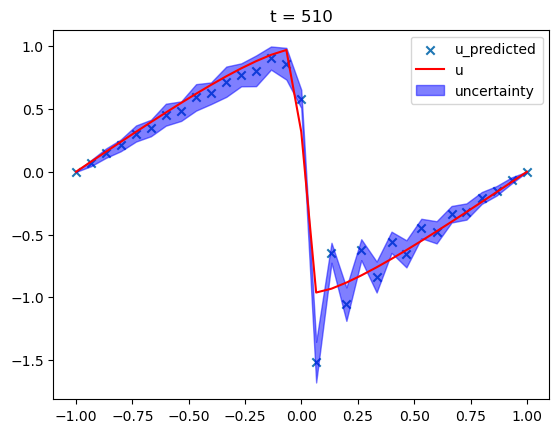

Time step 511 is done. Time taken: 0.721930980682373
Time step 512 is done. Time taken: 0.7654798030853271
Time step 513 is done. Time taken: 0.8457200527191162
Time step 514 is done. Time taken: 0.7951319217681885
Time step 515 is done. Time taken: 0.7240700721740723
Time step 516 is done. Time taken: 0.7015748023986816
Time step 517 is done. Time taken: 0.8100309371948242
Time step 518 is done. Time taken: 0.7135012149810791
Time step 519 is done. Time taken: 0.6953780651092529
Time step 520 is done. Time taken: 0.673271894454956


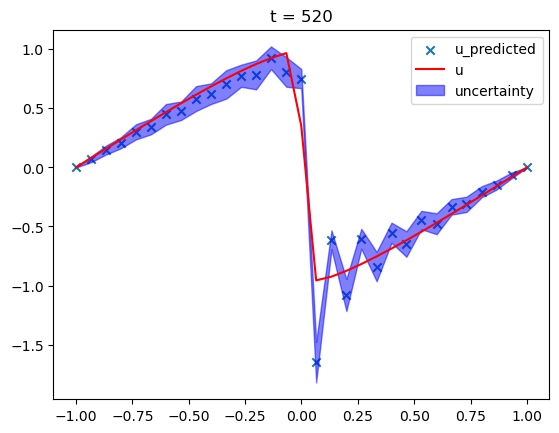

Time step 521 is done. Time taken: 0.7123241424560547
Time step 522 is done. Time taken: 0.7685840129852295
Time step 523 is done. Time taken: 0.6938118934631348
Time step 524 is done. Time taken: 0.7382950782775879
Time step 525 is done. Time taken: 0.9400019645690918
Time step 526 is done. Time taken: 0.7339153289794922
Time step 527 is done. Time taken: 0.7049810886383057
Time step 528 is done. Time taken: 0.7174761295318604
Time step 529 is done. Time taken: 0.7138040065765381
Time step 530 is done. Time taken: 0.7203636169433594


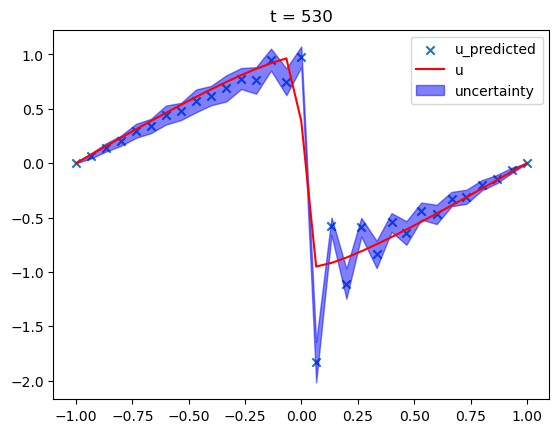

Time step 531 is done. Time taken: 0.7409369945526123
Time step 532 is done. Time taken: 0.7257051467895508
Time step 533 is done. Time taken: 0.7109880447387695
Time step 534 is done. Time taken: 0.7090082168579102
Time step 535 is done. Time taken: 0.7267677783966064
Time step 536 is done. Time taken: 0.7293078899383545
Time step 537 is done. Time taken: 0.8295040130615234
Time step 538 is done. Time taken: 0.7411079406738281
Time step 539 is done. Time taken: 0.7462127208709717
Time step 540 is done. Time taken: 0.7210960388183594


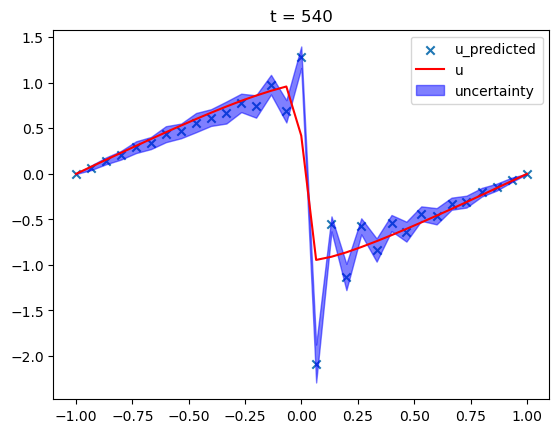

Time step 541 is done. Time taken: 0.7667639255523682
Time step 542 is done. Time taken: 0.7435681819915771
Time step 543 is done. Time taken: 0.7251520156860352
Time step 544 is done. Time taken: 0.7707831859588623
Time step 545 is done. Time taken: 0.805131196975708
Time step 546 is done. Time taken: 0.7081599235534668
Time step 547 is done. Time taken: 0.7156198024749756
Time step 548 is done. Time taken: 0.7007348537445068
Time step 549 is done. Time taken: 0.7227499485015869
Time step 550 is done. Time taken: 0.7509617805480957


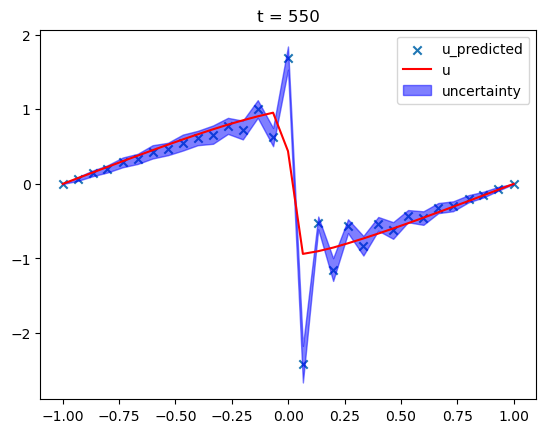

Time step 551 is done. Time taken: 0.7862269878387451
Time step 552 is done. Time taken: 0.7745859622955322
Time step 553 is done. Time taken: 0.7228739261627197
Time step 554 is done. Time taken: 0.7401201725006104
Time step 555 is done. Time taken: 0.716778039932251
Time step 556 is done. Time taken: 0.6916899681091309
Time step 557 is done. Time taken: 0.7118911743164062
Time step 558 is done. Time taken: 0.6903460025787354
Time step 559 is done. Time taken: 0.8076310157775879
Time step 560 is done. Time taken: 0.7031869888305664


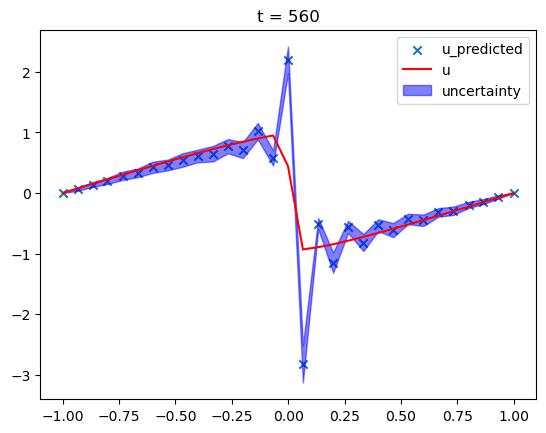

Time step 561 is done. Time taken: 0.7263062000274658
Time step 562 is done. Time taken: 0.6884558200836182
Time step 563 is done. Time taken: 0.7006289958953857
Time step 564 is done. Time taken: 0.6922738552093506
Time step 565 is done. Time taken: 0.6844940185546875
Time step 566 is done. Time taken: 0.8063468933105469
Time step 567 is done. Time taken: 0.8734750747680664
Time step 568 is done. Time taken: 1.23390531539917
Time step 569 is done. Time taken: 2.4742908477783203
Time step 570 is done. Time taken: 1.003521203994751


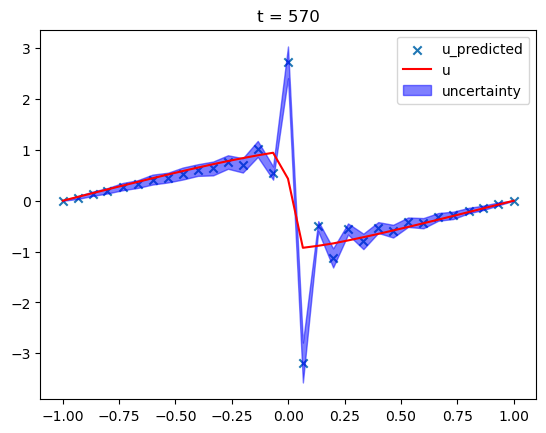

Time step 571 is done. Time taken: 0.9499568939208984
Time step 572 is done. Time taken: 0.9878866672515869
Time step 573 is done. Time taken: 0.7547459602355957
Time step 574 is done. Time taken: 0.7557640075683594
Time step 575 is done. Time taken: 0.8234832286834717
Time step 576 is done. Time taken: 0.7099969387054443
Time step 577 is done. Time taken: 0.7456316947937012
Time step 578 is done. Time taken: 0.7287280559539795
Time step 579 is done. Time taken: 0.7708759307861328
Time step 580 is done. Time taken: 0.7087571620941162


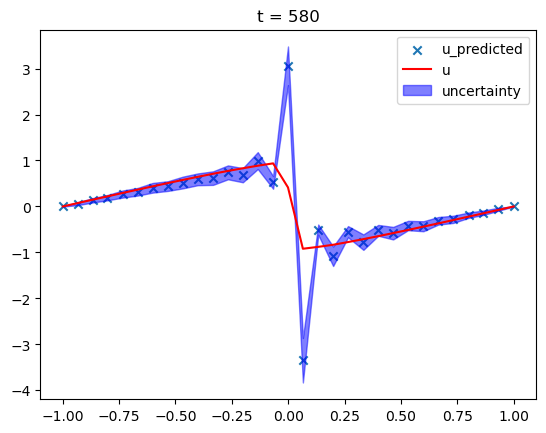

Time step 581 is done. Time taken: 0.7016019821166992
Time step 582 is done. Time taken: 0.6832890510559082
Time step 583 is done. Time taken: 0.6908988952636719
Time step 584 is done. Time taken: 0.7242529392242432
Time step 585 is done. Time taken: 0.7366180419921875
Time step 586 is done. Time taken: 0.7393462657928467
Time step 587 is done. Time taken: 0.746013879776001
Time step 588 is done. Time taken: 0.7289159297943115
Time step 589 is done. Time taken: 0.7345871925354004
Time step 590 is done. Time taken: 0.7213029861450195


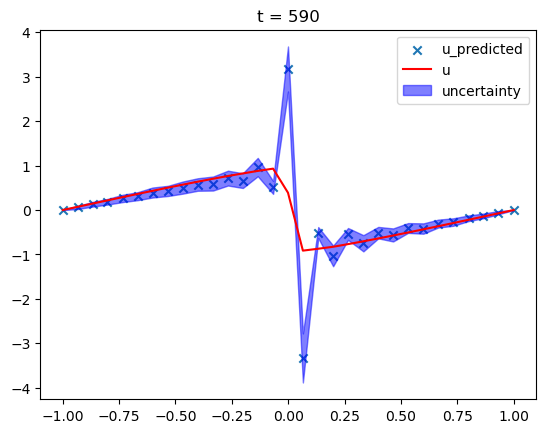

Time step 591 is done. Time taken: 0.7666418552398682
Time step 592 is done. Time taken: 0.8488030433654785
Time step 593 is done. Time taken: 0.7405171394348145
Time step 594 is done. Time taken: 0.7278749942779541
Time step 595 is done. Time taken: 1.1208901405334473
Time step 596 is done. Time taken: 0.8516538143157959
Time step 597 is done. Time taken: 0.7416708469390869
Time step 598 is done. Time taken: 0.7243261337280273
Time step 599 is done. Time taken: 0.7099461555480957
Time step 600 is done. Time taken: 0.7020857334136963


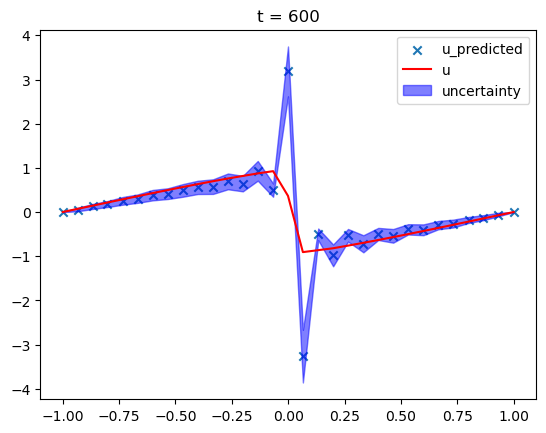

Time step 601 is done. Time taken: 0.7375969886779785
Time step 602 is done. Time taken: 0.6905200481414795
Time step 603 is done. Time taken: 0.693526029586792
Time step 604 is done. Time taken: 4.075206995010376
Time step 605 is done. Time taken: 0.7340328693389893
Time step 606 is done. Time taken: 0.6894311904907227
Time step 607 is done. Time taken: 0.6910891532897949
Time step 608 is done. Time taken: 0.8142209053039551
Time step 609 is done. Time taken: 0.7739889621734619
Time step 610 is done. Time taken: 0.6797990798950195


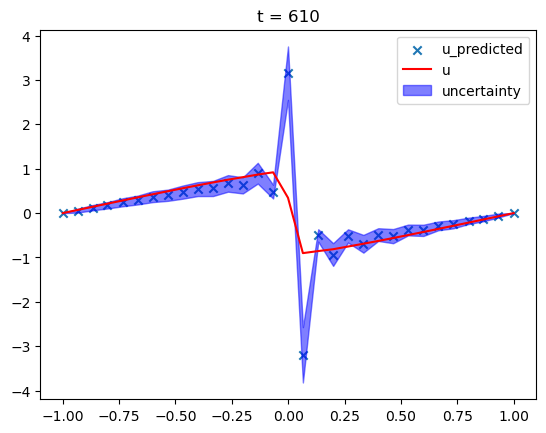

Time step 611 is done. Time taken: 0.7461960315704346
Time step 612 is done. Time taken: 0.6839029788970947
Time step 613 is done. Time taken: 0.6736478805541992
Time step 614 is done. Time taken: 0.704124927520752
Time step 615 is done. Time taken: 0.6764171123504639
Time step 616 is done. Time taken: 0.733151912689209
Time step 617 is done. Time taken: 0.6700289249420166
Time step 618 is done. Time taken: 0.6858000755310059
Time step 619 is done. Time taken: 0.6772429943084717
Time step 620 is done. Time taken: 0.6877851486206055


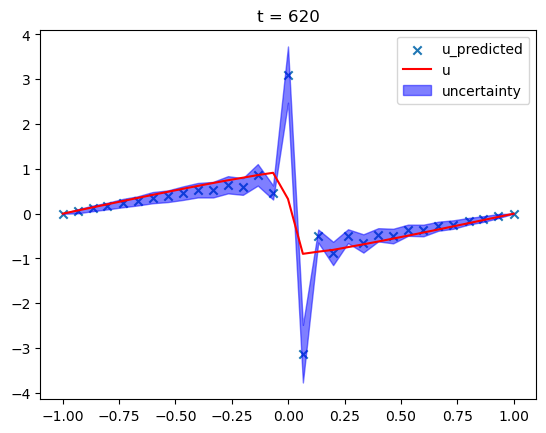

Time step 621 is done. Time taken: 0.6996409893035889
Time step 622 is done. Time taken: 0.7665700912475586
Time step 623 is done. Time taken: 0.6942822933197021
Time step 624 is done. Time taken: 0.7623000144958496
Time step 625 is done. Time taken: 0.7107887268066406
Time step 626 is done. Time taken: 0.6803038120269775
Time step 627 is done. Time taken: 0.7011122703552246
Time step 628 is done. Time taken: 0.712451696395874
Time step 629 is done. Time taken: 0.6785199642181396
Time step 630 is done. Time taken: 0.6774778366088867


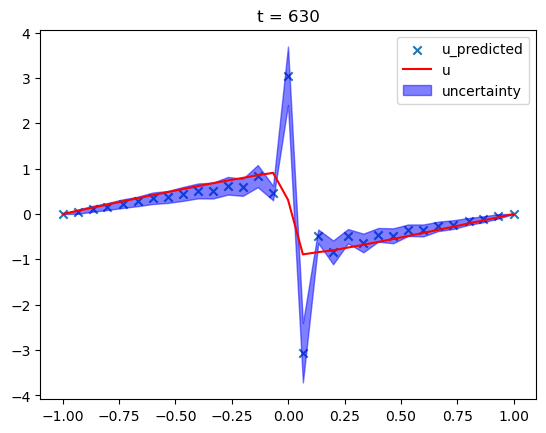

Time step 631 is done. Time taken: 0.7083909511566162
Time step 632 is done. Time taken: 0.6792888641357422
Time step 633 is done. Time taken: 0.7552251815795898
Time step 634 is done. Time taken: 0.7395720481872559
Time step 635 is done. Time taken: 0.6929950714111328
Time step 636 is done. Time taken: 0.7215108871459961
Time step 637 is done. Time taken: 0.6712870597839355
Time step 638 is done. Time taken: 0.6792008876800537
Time step 639 is done. Time taken: 0.6787619590759277
Time step 640 is done. Time taken: 0.6965901851654053


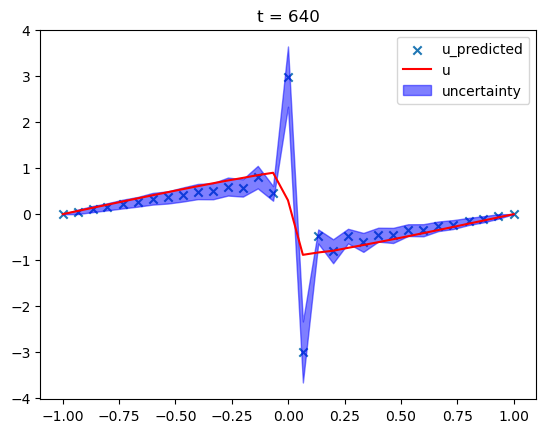

Time step 641 is done. Time taken: 0.7040579319000244
Time step 642 is done. Time taken: 0.6842560768127441
Time step 643 is done. Time taken: 0.6697158813476562
Time step 644 is done. Time taken: 0.6669471263885498
Time step 645 is done. Time taken: 0.6733181476593018
Time step 646 is done. Time taken: 0.6753170490264893
Time step 647 is done. Time taken: 0.6770322322845459
Time step 648 is done. Time taken: 0.6824898719787598
Time step 649 is done. Time taken: 0.6966009140014648
Time step 650 is done. Time taken: 0.6848487854003906


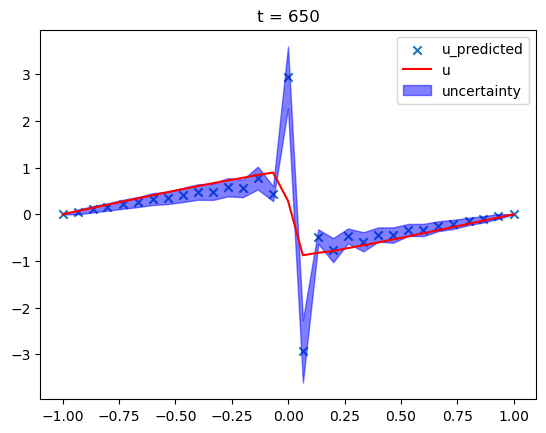

Time step 651 is done. Time taken: 0.7059497833251953
Time step 652 is done. Time taken: 0.6790909767150879
Time step 653 is done. Time taken: 0.6665809154510498
Time step 654 is done. Time taken: 0.6739168167114258
Time step 655 is done. Time taken: 0.6734459400177002
Time step 656 is done. Time taken: 0.6713848114013672
Time step 657 is done. Time taken: 0.6732349395751953
Time step 658 is done. Time taken: 0.6735532283782959
Time step 659 is done. Time taken: 0.6720600128173828
Time step 660 is done. Time taken: 0.7176249027252197


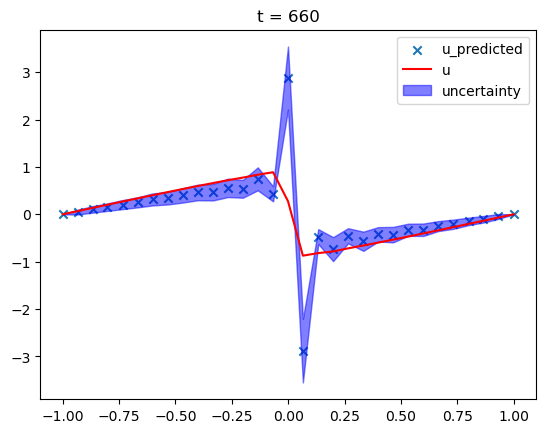

Time step 661 is done. Time taken: 0.7800440788269043
Time step 662 is done. Time taken: 0.6732630729675293
Time step 663 is done. Time taken: 0.6720330715179443
Time step 664 is done. Time taken: 0.6750578880310059
Time step 665 is done. Time taken: 0.6797387599945068
Time step 666 is done. Time taken: 0.6702642440795898
Time step 667 is done. Time taken: 0.6794638633728027
Time step 668 is done. Time taken: 0.6768307685852051
Time step 669 is done. Time taken: 0.6680819988250732
Time step 670 is done. Time taken: 0.6837079524993896


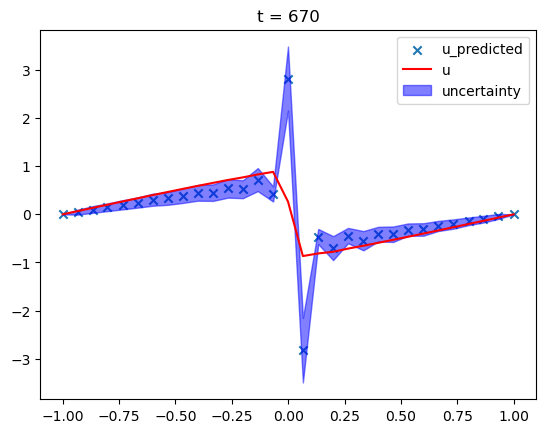

Time step 671 is done. Time taken: 0.7021939754486084
Time step 672 is done. Time taken: 0.6679360866546631
Time step 673 is done. Time taken: 0.6817328929901123
Time step 674 is done. Time taken: 0.6760890483856201
Time step 675 is done. Time taken: 0.6749019622802734
Time step 676 is done. Time taken: 0.6718416213989258
Time step 677 is done. Time taken: 0.6711721420288086
Time step 678 is done. Time taken: 0.6684839725494385
Time step 679 is done. Time taken: 0.6714057922363281
Time step 680 is done. Time taken: 0.6868040561676025


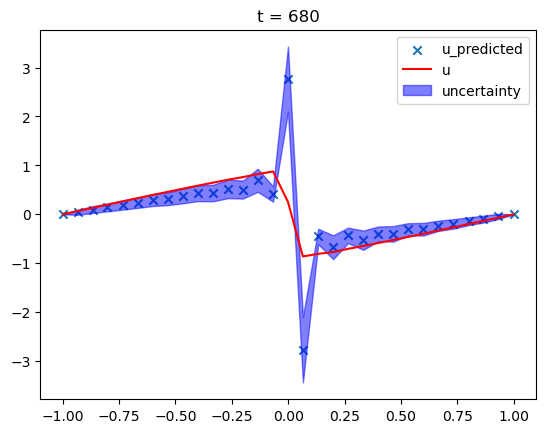

Time step 681 is done. Time taken: 0.695537805557251
Time step 682 is done. Time taken: 0.7621040344238281
Time step 683 is done. Time taken: 0.6945571899414062
Time step 684 is done. Time taken: 0.6820089817047119
Time step 685 is done. Time taken: 0.6834239959716797
Time step 686 is done. Time taken: 0.6784610748291016
Time step 687 is done. Time taken: 0.6682939529418945
Time step 688 is done. Time taken: 0.6789150238037109
Time step 689 is done. Time taken: 0.6737322807312012
Time step 690 is done. Time taken: 0.6777908802032471


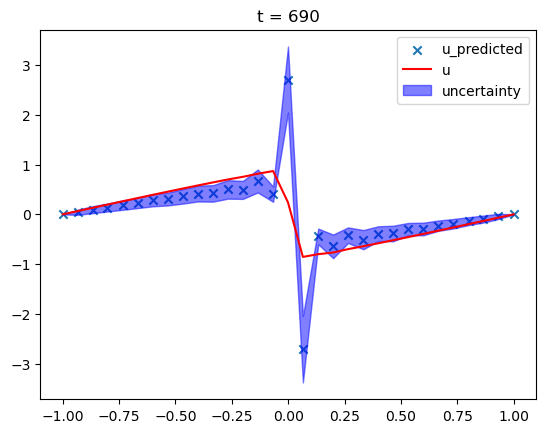

Time step 691 is done. Time taken: 0.7051892280578613
Time step 692 is done. Time taken: 0.6720318794250488
Time step 693 is done. Time taken: 0.6741347312927246
Time step 694 is done. Time taken: 0.6786191463470459
Time step 695 is done. Time taken: 0.6780610084533691
Time step 696 is done. Time taken: 0.6708779335021973
Time step 697 is done. Time taken: 0.6761741638183594
Time step 698 is done. Time taken: 0.6789700984954834
Time step 699 is done. Time taken: 0.6722359657287598
Time step 700 is done. Time taken: 0.6668269634246826


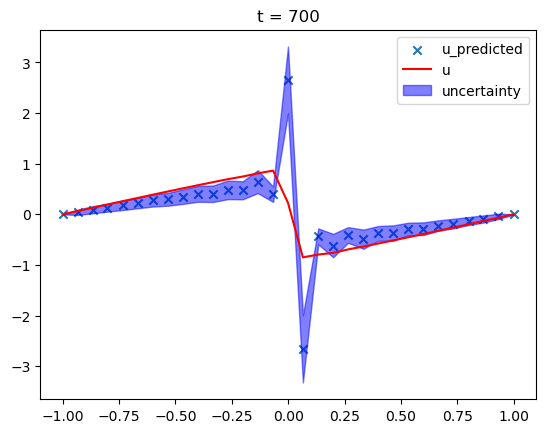

Time step 701 is done. Time taken: 0.6909430027008057
Time step 702 is done. Time taken: 0.6788389682769775
Time step 703 is done. Time taken: 0.7624850273132324
Time step 704 is done. Time taken: 0.6908471584320068
Time step 705 is done. Time taken: 0.6733059883117676
Time step 706 is done. Time taken: 0.6865959167480469
Time step 707 is done. Time taken: 0.6656098365783691
Time step 708 is done. Time taken: 0.6738789081573486
Time step 709 is done. Time taken: 0.6723830699920654
Time step 710 is done. Time taken: 0.6723089218139648


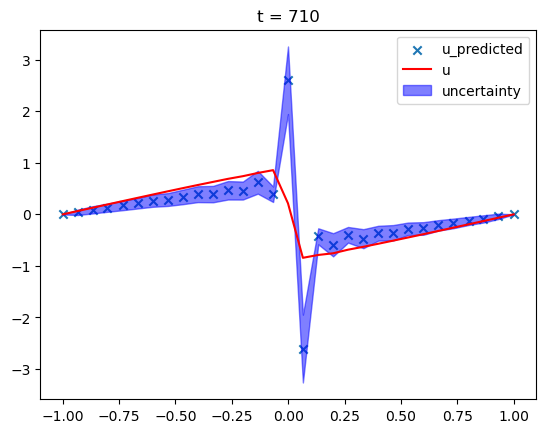

Time step 711 is done. Time taken: 0.6924033164978027
Time step 712 is done. Time taken: 0.6703829765319824
Time step 713 is done. Time taken: 3.7872371673583984
Time step 714 is done. Time taken: 0.6900219917297363
Time step 715 is done. Time taken: 0.6812920570373535
Time step 716 is done. Time taken: 0.6826820373535156
Time step 717 is done. Time taken: 0.6739072799682617
Time step 718 is done. Time taken: 0.6726078987121582
Time step 719 is done. Time taken: 0.6745920181274414
Time step 720 is done. Time taken: 0.6721727848052979


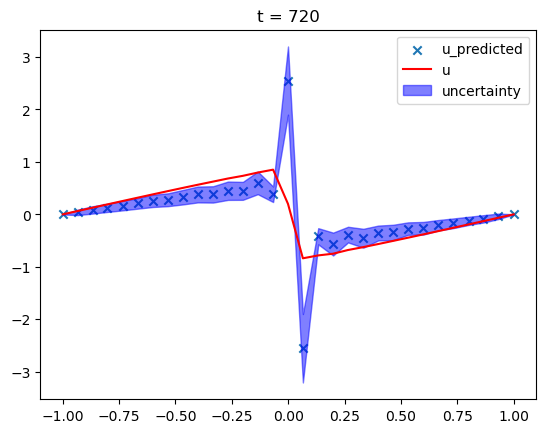

Time step 721 is done. Time taken: 0.7217850685119629
Time step 722 is done. Time taken: 0.67392897605896
Time step 723 is done. Time taken: 0.6692519187927246
Time step 724 is done. Time taken: 0.6783938407897949
Time step 725 is done. Time taken: 0.6724228858947754
Time step 726 is done. Time taken: 0.6696929931640625
Time step 727 is done. Time taken: 0.6797642707824707
Time step 728 is done. Time taken: 0.6691000461578369
Time step 729 is done. Time taken: 0.6715908050537109
Time step 730 is done. Time taken: 0.679783821105957


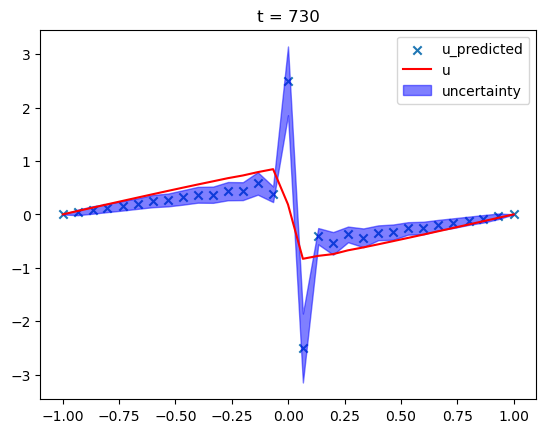

Time step 731 is done. Time taken: 0.6848969459533691
Time step 732 is done. Time taken: 0.7531492710113525
Time step 733 is done. Time taken: 0.6707520484924316
Time step 734 is done. Time taken: 0.6863670349121094
Time step 735 is done. Time taken: 0.6681642532348633
Time step 736 is done. Time taken: 0.672187089920044
Time step 737 is done. Time taken: 0.6732690334320068
Time step 738 is done. Time taken: 0.6695270538330078
Time step 739 is done. Time taken: 0.6785058975219727
Time step 740 is done. Time taken: 0.6875157356262207


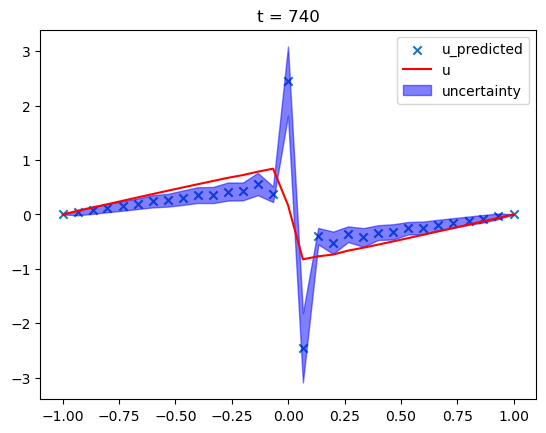

Time step 741 is done. Time taken: 0.6935100555419922
Time step 742 is done. Time taken: 0.6750199794769287
Time step 743 is done. Time taken: 0.678023099899292
Time step 744 is done. Time taken: 0.6809971332550049
Time step 745 is done. Time taken: 0.6749770641326904
Time step 746 is done. Time taken: 0.6691441535949707
Time step 747 is done. Time taken: 0.6715800762176514
Time step 748 is done. Time taken: 0.6712520122528076
Time step 749 is done. Time taken: 0.670241117477417
Time step 750 is done. Time taken: 0.6670918464660645


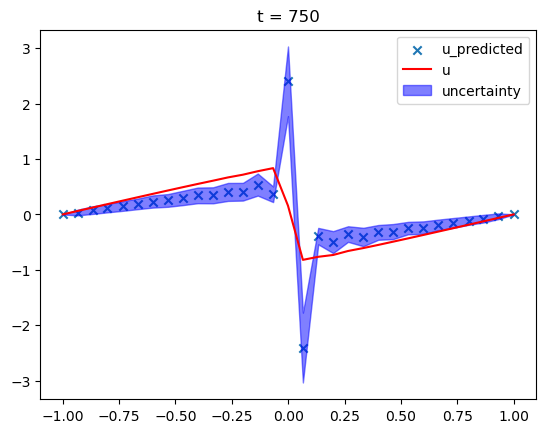

Time step 751 is done. Time taken: 0.6934089660644531
Time step 752 is done. Time taken: 0.7543859481811523
Time step 753 is done. Time taken: 0.6782398223876953
Time step 754 is done. Time taken: 0.6831872463226318
Time step 755 is done. Time taken: 0.6721110343933105
Time step 756 is done. Time taken: 0.6857700347900391
Time step 757 is done. Time taken: 0.6819620132446289
Time step 758 is done. Time taken: 0.6700940132141113
Time step 759 is done. Time taken: 0.6787638664245605
Time step 760 is done. Time taken: 0.6684620380401611


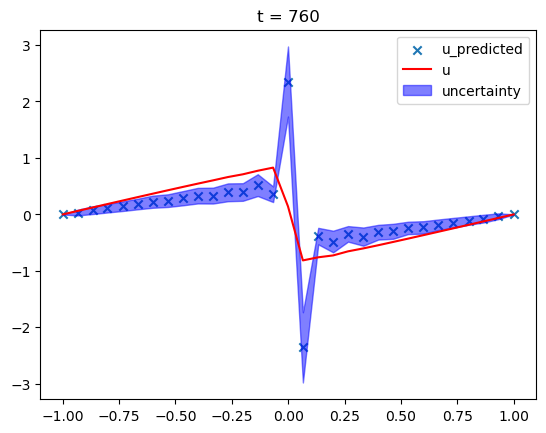

Time step 761 is done. Time taken: 0.6986477375030518
Time step 762 is done. Time taken: 0.6799547672271729
Time step 763 is done. Time taken: 0.6714808940887451
Time step 764 is done. Time taken: 0.6725859642028809
Time step 765 is done. Time taken: 0.6724212169647217
Time step 766 is done. Time taken: 0.6753590106964111
Time step 767 is done. Time taken: 0.6886498928070068
Time step 768 is done. Time taken: 0.6732048988342285
Time step 769 is done. Time taken: 0.6757676601409912
Time step 770 is done. Time taken: 0.6717700958251953


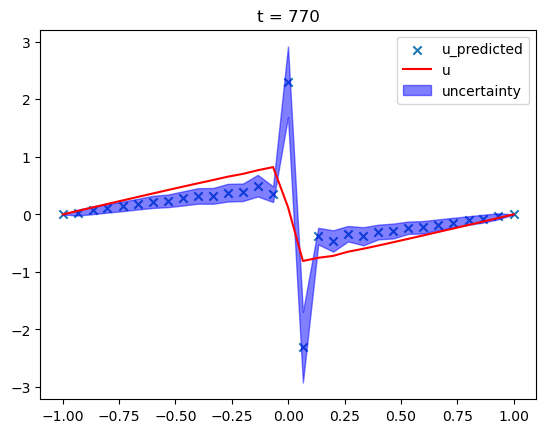

Time step 771 is done. Time taken: 0.6886880397796631
Time step 772 is done. Time taken: 0.75701904296875
Time step 773 is done. Time taken: 0.675961971282959
Time step 774 is done. Time taken: 0.6730132102966309
Time step 775 is done. Time taken: 0.6717479228973389
Time step 776 is done. Time taken: 0.6810319423675537
Time step 777 is done. Time taken: 0.6869790554046631
Time step 778 is done. Time taken: 0.6756868362426758
Time step 779 is done. Time taken: 0.6776471138000488
Time step 780 is done. Time taken: 0.6705338954925537


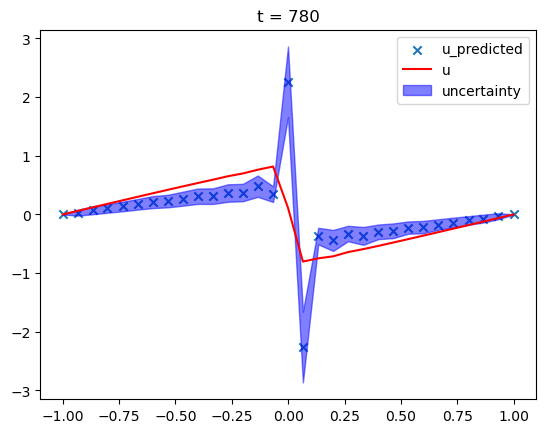

Time step 781 is done. Time taken: 0.7091560363769531
Time step 782 is done. Time taken: 0.6788249015808105
Time step 783 is done. Time taken: 0.6730959415435791
Time step 784 is done. Time taken: 0.6732852458953857
Time step 785 is done. Time taken: 0.6717398166656494
Time step 786 is done. Time taken: 0.6740260124206543
Time step 787 is done. Time taken: 0.6700930595397949
Time step 788 is done. Time taken: 0.6823728084564209
Time step 789 is done. Time taken: 0.6826491355895996
Time step 790 is done. Time taken: 0.7009289264678955


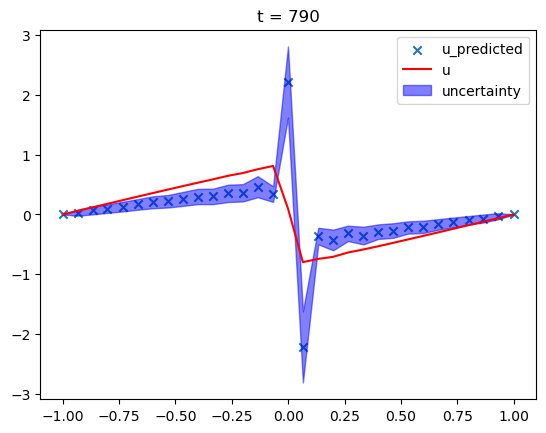

Time step 791 is done. Time taken: 0.7375891208648682
Time step 792 is done. Time taken: 0.7704172134399414
Time step 793 is done. Time taken: 0.6868059635162354
Time step 794 is done. Time taken: 0.6750268936157227
Time step 795 is done. Time taken: 0.681678056716919
Time step 796 is done. Time taken: 0.7419819831848145
Time step 797 is done. Time taken: 0.6787679195404053
Time step 798 is done. Time taken: 0.6761720180511475
Time step 799 is done. Time taken: 0.6784379482269287
Time step 800 is done. Time taken: 0.675015926361084


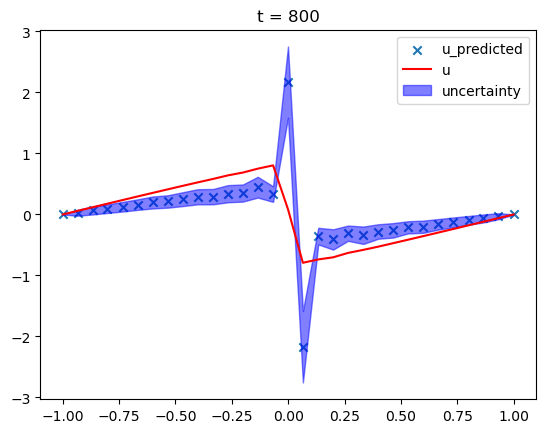

Time step 801 is done. Time taken: 0.6943478584289551
Time step 802 is done. Time taken: 0.7568917274475098
Time step 803 is done. Time taken: 0.6732990741729736
Time step 804 is done. Time taken: 0.6787102222442627
Time step 805 is done. Time taken: 0.6908388137817383
Time step 806 is done. Time taken: 0.6717698574066162
Time step 807 is done. Time taken: 0.6958999633789062
Time step 808 is done. Time taken: 0.6795699596405029
Time step 809 is done. Time taken: 0.6743450164794922
Time step 810 is done. Time taken: 0.6697618961334229


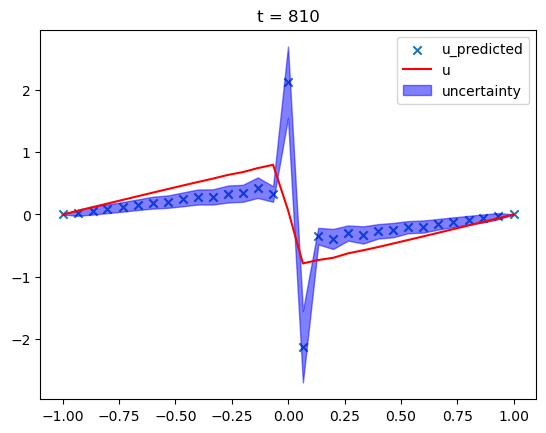

Time step 811 is done. Time taken: 0.7051889896392822
Time step 812 is done. Time taken: 0.6697719097137451
Time step 813 is done. Time taken: 0.6712460517883301
Time step 814 is done. Time taken: 0.6732621192932129
Time step 815 is done. Time taken: 0.6746749877929688
Time step 816 is done. Time taken: 0.6802492141723633
Time step 817 is done. Time taken: 0.6712510585784912
Time step 818 is done. Time taken: 0.6752970218658447
Time step 819 is done. Time taken: 0.6729552745819092
Time step 820 is done. Time taken: 0.6734619140625


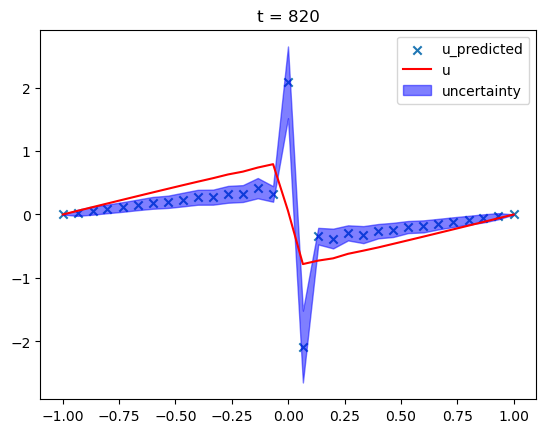

Time step 821 is done. Time taken: 0.7034828662872314
Time step 822 is done. Time taken: 0.7469809055328369
Time step 823 is done. Time taken: 0.6769530773162842
Time step 824 is done. Time taken: 0.6798069477081299
Time step 825 is done. Time taken: 0.6778101921081543
Time step 826 is done. Time taken: 0.6692919731140137
Time step 827 is done. Time taken: 0.6891818046569824
Time step 828 is done. Time taken: 0.6687438488006592
Time step 829 is done. Time taken: 0.675227165222168
Time step 830 is done. Time taken: 4.0548059940338135


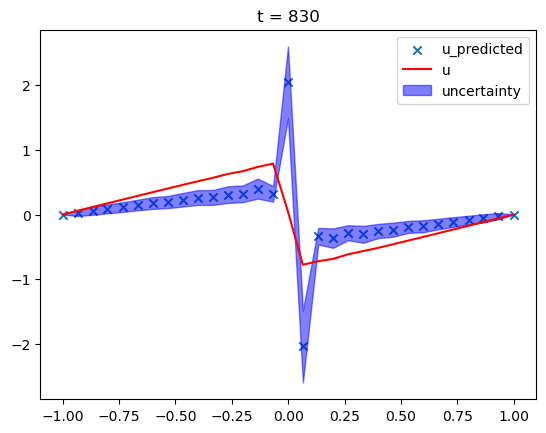

Time step 831 is done. Time taken: 0.7467069625854492
Time step 832 is done. Time taken: 0.6858282089233398
Time step 833 is done. Time taken: 0.6741259098052979
Time step 834 is done. Time taken: 0.6765639781951904
Time step 835 is done. Time taken: 0.689180850982666
Time step 836 is done. Time taken: 0.6680269241333008
Time step 837 is done. Time taken: 0.6699032783508301
Time step 838 is done. Time taken: 0.6679248809814453
Time step 839 is done. Time taken: 0.6631290912628174
Time step 840 is done. Time taken: 0.668208122253418


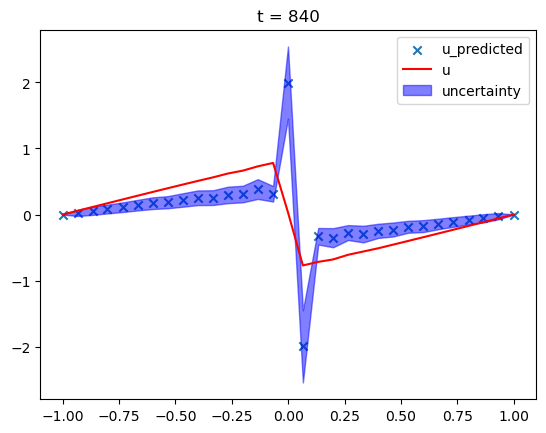

Time step 841 is done. Time taken: 0.6882801055908203
Time step 842 is done. Time taken: 0.6714780330657959
Time step 843 is done. Time taken: 0.669529914855957
Time step 844 is done. Time taken: 0.6785778999328613
Time step 845 is done. Time taken: 0.6703269481658936
Time step 846 is done. Time taken: 0.67156982421875
Time step 847 is done. Time taken: 0.6718978881835938
Time step 848 is done. Time taken: 0.6907320022583008
Time step 849 is done. Time taken: 0.6750650405883789
Time step 850 is done. Time taken: 0.674246072769165


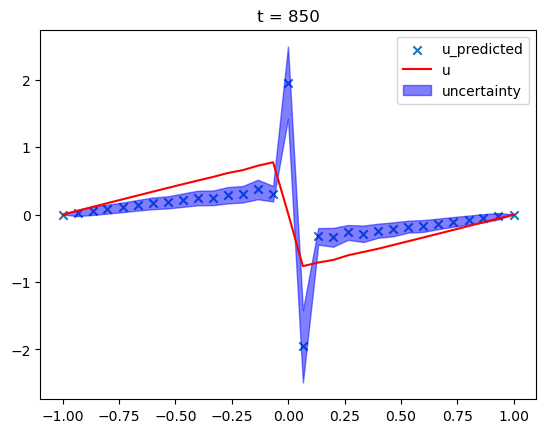

Time step 851 is done. Time taken: 0.7834320068359375
Time step 852 is done. Time taken: 0.6752378940582275
Time step 853 is done. Time taken: 0.6796829700469971
Time step 854 is done. Time taken: 0.6676242351531982
Time step 855 is done. Time taken: 0.6702399253845215
Time step 856 is done. Time taken: 0.6710109710693359
Time step 857 is done. Time taken: 0.6700420379638672
Time step 858 is done. Time taken: 0.6705977916717529
Time step 859 is done. Time taken: 0.6772511005401611
Time step 860 is done. Time taken: 0.6704502105712891


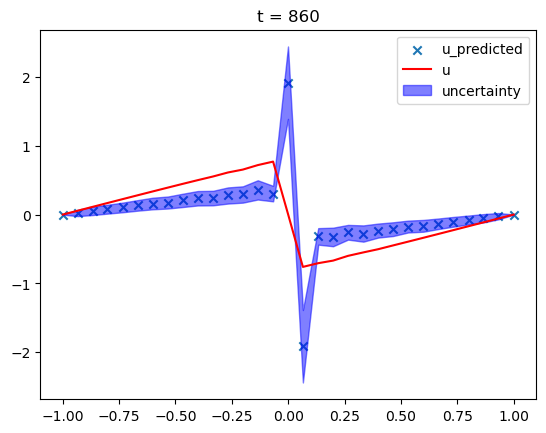

Time step 861 is done. Time taken: 0.6992840766906738
Time step 862 is done. Time taken: 0.6792769432067871
Time step 863 is done. Time taken: 0.6709539890289307
Time step 864 is done. Time taken: 0.6722018718719482
Time step 865 is done. Time taken: 0.6664390563964844
Time step 866 is done. Time taken: 0.6642999649047852
Time step 867 is done. Time taken: 0.6889362335205078
Time step 868 is done. Time taken: 0.7386329174041748
Time step 869 is done. Time taken: 0.674422025680542
Time step 870 is done. Time taken: 0.6796388626098633


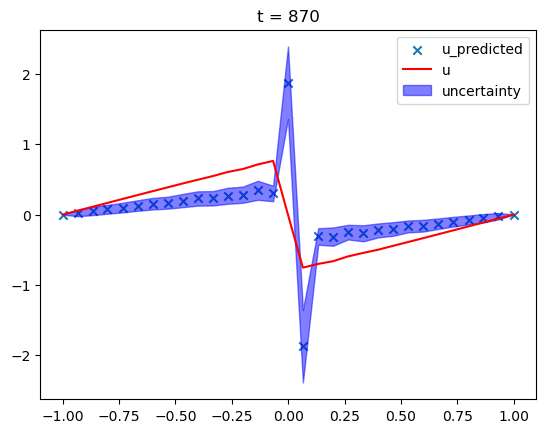

Time step 871 is done. Time taken: 0.7025959491729736
Time step 872 is done. Time taken: 0.7595219612121582
Time step 873 is done. Time taken: 0.6669919490814209
Time step 874 is done. Time taken: 0.7422568798065186
Time step 875 is done. Time taken: 0.7680583000183105
Time step 876 is done. Time taken: 0.7323670387268066
Time step 877 is done. Time taken: 0.7329647541046143
Time step 878 is done. Time taken: 0.8033008575439453
Time step 879 is done. Time taken: 0.7281100749969482
Time step 880 is done. Time taken: 0.7791681289672852


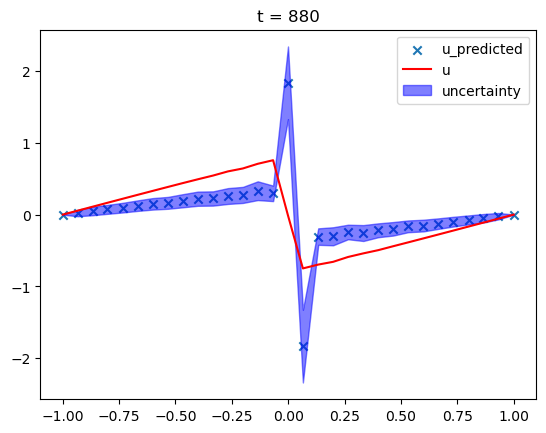

Time step 881 is done. Time taken: 0.9715027809143066
Time step 882 is done. Time taken: 1.0926451683044434
Time step 883 is done. Time taken: 0.8411400318145752
Time step 884 is done. Time taken: 0.7191691398620605
Time step 885 is done. Time taken: 0.6848750114440918
Time step 886 is done. Time taken: 0.683635950088501
Time step 887 is done. Time taken: 0.6854698657989502
Time step 888 is done. Time taken: 0.6829633712768555
Time step 889 is done. Time taken: 0.6785168647766113
Time step 890 is done. Time taken: 0.9458708763122559


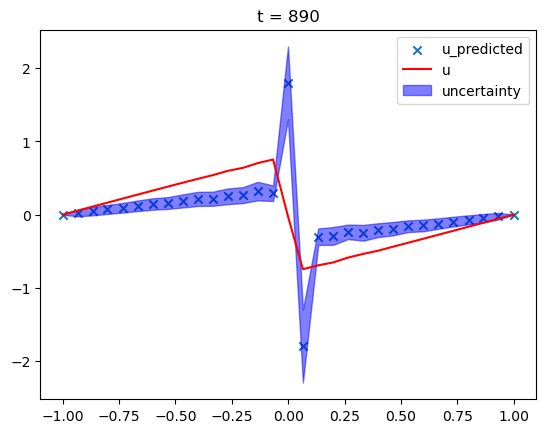

Time step 891 is done. Time taken: 0.8137247562408447
Time step 892 is done. Time taken: 1.0827608108520508
Time step 893 is done. Time taken: 0.7507007122039795
Time step 894 is done. Time taken: 0.7988779544830322
Time step 895 is done. Time taken: 0.7060019969940186
Time step 896 is done. Time taken: 0.8157529830932617
Time step 897 is done. Time taken: 0.8470118045806885
Time step 898 is done. Time taken: 0.7726900577545166
Time step 899 is done. Time taken: 0.7417862415313721
Time step 900 is done. Time taken: 0.8702709674835205


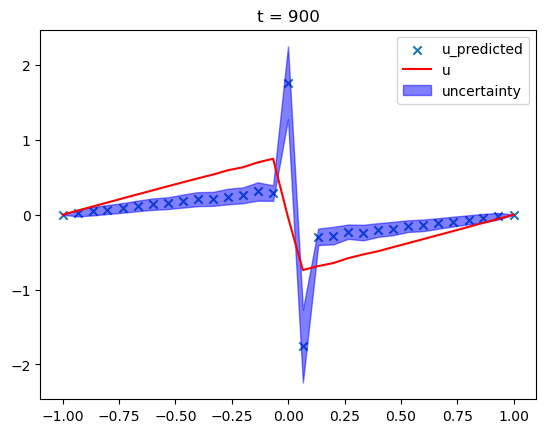

Time step 901 is done. Time taken: 0.7984528541564941
Time step 902 is done. Time taken: 0.8251733779907227
Time step 903 is done. Time taken: 0.7522499561309814
Time step 904 is done. Time taken: 0.8719210624694824
Time step 905 is done. Time taken: 0.9887759685516357
Time step 906 is done. Time taken: 0.7322580814361572
Time step 907 is done. Time taken: 0.8004651069641113
Time step 908 is done. Time taken: 1.060943841934204
Time step 909 is done. Time taken: 1.349759817123413
Time step 910 is done. Time taken: 1.018507957458496


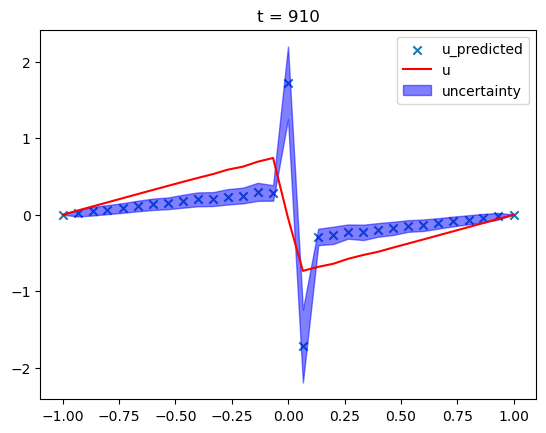

Time step 911 is done. Time taken: 0.8073549270629883
Time step 912 is done. Time taken: 1.0062782764434814
Time step 913 is done. Time taken: 0.7708368301391602
Time step 914 is done. Time taken: 0.722020149230957
Time step 915 is done. Time taken: 0.8861923217773438
Time step 916 is done. Time taken: 0.8311328887939453
Time step 917 is done. Time taken: 0.721552848815918
Time step 918 is done. Time taken: 0.7116339206695557
Time step 919 is done. Time taken: 0.8289132118225098
Time step 920 is done. Time taken: 0.7299377918243408


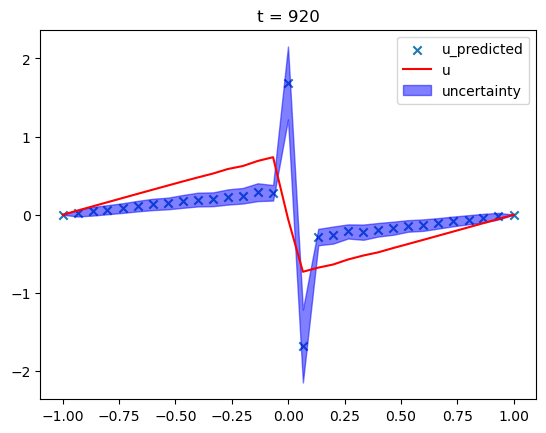

Time step 921 is done. Time taken: 0.8642680644989014
Time step 922 is done. Time taken: 0.9565310478210449
Time step 923 is done. Time taken: 0.7440218925476074
Time step 924 is done. Time taken: 0.724139928817749
Time step 925 is done. Time taken: 0.7270221710205078
Time step 926 is done. Time taken: 0.7768418788909912
Time step 927 is done. Time taken: 0.7005360126495361
Time step 928 is done. Time taken: 0.7063028812408447
Time step 929 is done. Time taken: 0.7061038017272949
Time step 930 is done. Time taken: 0.7018082141876221


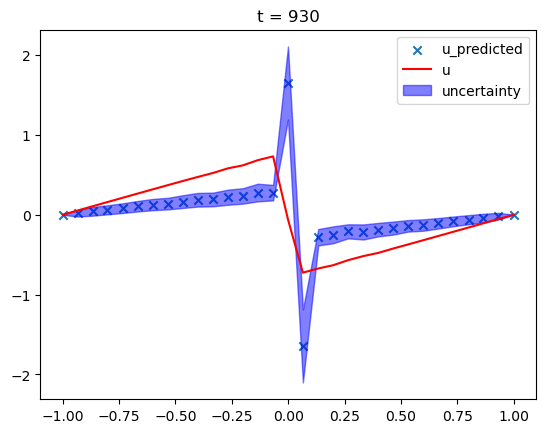

Time step 931 is done. Time taken: 0.7215538024902344
Time step 932 is done. Time taken: 0.7661838531494141
Time step 933 is done. Time taken: 0.693105936050415
Time step 934 is done. Time taken: 0.7486860752105713
Time step 935 is done. Time taken: 0.7117700576782227
Time step 936 is done. Time taken: 0.722437858581543
Time step 937 is done. Time taken: 0.7097809314727783
Time step 938 is done. Time taken: 0.807049036026001
Time step 939 is done. Time taken: 0.7222189903259277
Time step 940 is done. Time taken: 0.7266499996185303


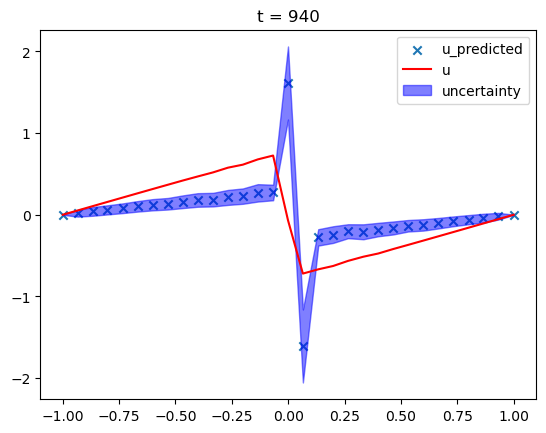

Time step 941 is done. Time taken: 0.732050895690918
Time step 942 is done. Time taken: 0.7793490886688232
Time step 943 is done. Time taken: 0.7622671127319336
Time step 944 is done. Time taken: 0.7859621047973633
Time step 945 is done. Time taken: 0.9321789741516113
Time step 946 is done. Time taken: 0.728367805480957
Time step 947 is done. Time taken: 0.6845629215240479
Time step 948 is done. Time taken: 0.6958720684051514
Time step 949 is done. Time taken: 0.7950828075408936
Time step 950 is done. Time taken: 0.7104330062866211


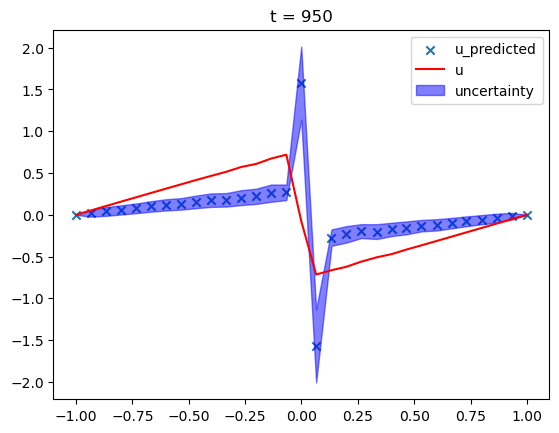

Time step 951 is done. Time taken: 0.8449499607086182
Time step 952 is done. Time taken: 0.846013069152832
Time step 953 is done. Time taken: 0.7596893310546875
Time step 954 is done. Time taken: 5.589154005050659
Time step 955 is done. Time taken: 0.9129471778869629
Time step 956 is done. Time taken: 0.8160359859466553
Time step 957 is done. Time taken: 0.8546650409698486
Time step 958 is done. Time taken: 0.754688024520874
Time step 959 is done. Time taken: 0.7247681617736816
Time step 960 is done. Time taken: 0.7443830966949463


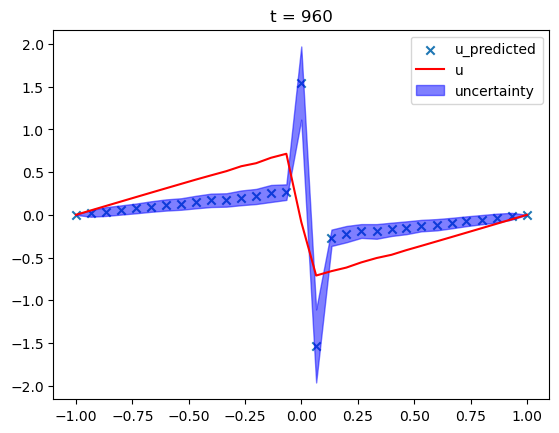

Time step 961 is done. Time taken: 0.7550110816955566
Time step 962 is done. Time taken: 0.8341131210327148
Time step 963 is done. Time taken: 0.739448070526123
Time step 964 is done. Time taken: 0.7285010814666748
Time step 965 is done. Time taken: 0.7294137477874756
Time step 966 is done. Time taken: 0.7435016632080078
Time step 967 is done. Time taken: 0.7758867740631104
Time step 968 is done. Time taken: 0.7510919570922852
Time step 969 is done. Time taken: 0.7266068458557129
Time step 970 is done. Time taken: 0.7510731220245361


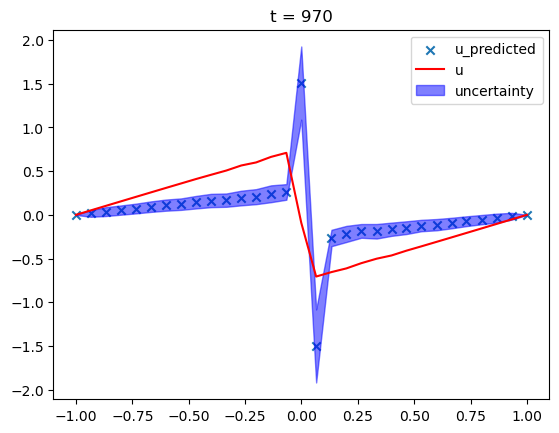

Time step 971 is done. Time taken: 0.7717719078063965
Time step 972 is done. Time taken: 0.8514811992645264
Time step 973 is done. Time taken: 0.7654902935028076
Time step 974 is done. Time taken: 0.7562310695648193
Time step 975 is done. Time taken: 0.7646710872650146
Time step 976 is done. Time taken: 0.835813045501709
Time step 977 is done. Time taken: 0.7278721332550049
Time step 978 is done. Time taken: 0.7003109455108643
Time step 979 is done. Time taken: 0.69777512550354
Time step 980 is done. Time taken: 0.6910789012908936


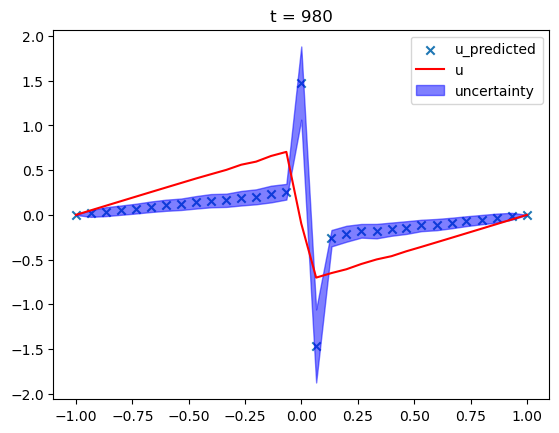

Time step 981 is done. Time taken: 0.7360620498657227
Time step 982 is done. Time taken: 0.7074391841888428
Time step 983 is done. Time taken: 0.6940310001373291
Time step 984 is done. Time taken: 0.6953210830688477
Time step 985 is done. Time taken: 0.6938760280609131
Time step 986 is done. Time taken: 0.6915678977966309
Time step 987 is done. Time taken: 0.6990442276000977
Time step 988 is done. Time taken: 0.6954548358917236
Time step 989 is done. Time taken: 0.6974520683288574
Time step 990 is done. Time taken: 0.6915609836578369


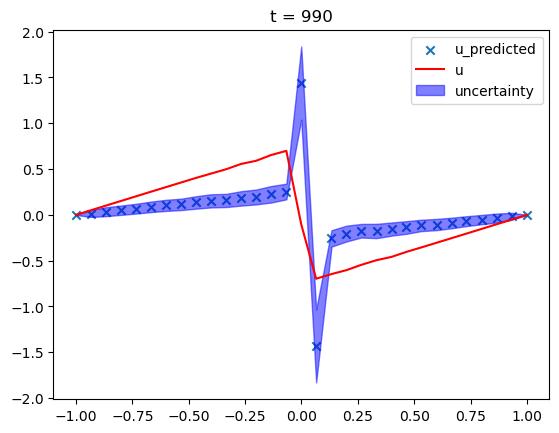

Time step 991 is done. Time taken: 0.8022499084472656
Time step 992 is done. Time taken: 0.6950480937957764
Time step 993 is done. Time taken: 0.7006058692932129
Time step 994 is done. Time taken: 0.6906130313873291
Time step 995 is done. Time taken: 0.6825659275054932
Time step 996 is done. Time taken: 0.6885769367218018
Time step 997 is done. Time taken: 0.6985931396484375
Time step 998 is done. Time taken: 0.6934828758239746
Time step 999 is done. Time taken: 0.6877710819244385
Time step 1000 is done. Time taken: 0.7029318809509277


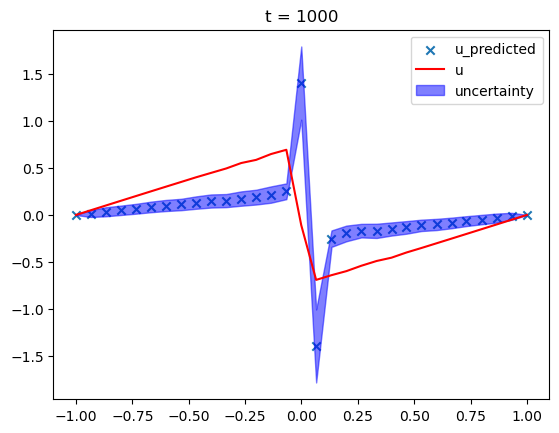

In [47]:
import time

# intial u0:
u0 = u_new[0,idx]

# initialize the accumulated uncertainty
updated_std = jnp.array([0]*n_test)

# initialize the covariance matrix
updated_cov = jnp.eye(n_test) * noise 
updated_std = jnp.sqrt(jnp.diag(updated_cov))

# updated_cov = jnp.eye(n_test) * 0

# initialize the error, u_mean, u_std
error, u_mean, u_std, u_true = [], [], [], []

for t in range(int(dt*1000), 1001, int(dt*1000)):
    # start a timer
    tstart = time.time()

    # u_train is the previous time step u and the boundary conditions
    # u_train = jnp.hstack([u0, u_new[t,bt_idx].T]).reshape(-1,1)
    u_train = jnp.hstack([u0, jnp.array([0,0])]).reshape(-1,1)
    X_train = jnp.vstack([x_train.T,t_train,mu_train]).T 

    dataset_train = gpx.Dataset(X_train, u_train)
    #remove the previous memory
    opt_posterior, history = gpx.fit(
        model=opt_posterior,
        objective=negative_mll,
        train_data=dataset_train,
        optim=ox.adamw(learning_rate=1e-2),
        num_iters=20,
        key = key,
        verbose = False,
        safe = False 
    )

    # latent_dist = opt_posterior.predict(X_test, train_data=dataset_train)
    latent_dist = opt_posterior.predict_with_prev_cov(X_test, train_data=dataset_train, prev_cov=updated_cov)
    predictive_dist = opt_posterior.likelihood(latent_dist)
    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    predictive_cov = predictive_dist.covariance()

    updated_std = predictive_std
    updated_cov = predictive_cov

    # the u that is predicted, use this u0 for the next time step
    u0 = predictive_mean

    # save the error
    error.append((u[t,idx] - predictive_mean)**2)
    u_mean.append(predictive_mean)
    u_std.append(updated_std)
    u_true.append(u[t,idx])

    # update the mu_train, and hence, dataset_train
    mu_train = jnp.hstack([u0, u_new[t,bt_idx]]).T


    print (f"Time step {t} is done. Time taken: {time.time() - tstart}")

In [48]:
# create the folder
import os

# file name 

foldername = f'Burger_RBF_{n_test}_test_points_{noise}_noise_{dt}_timestep'
folderpath = f'../../result/{foldername}'

if not os.path.exists(folderpath):
    os.makedirs(folderpath)

# save the error, u_mean, u_std, and x
np.save(f'{folderpath}/error.npy', np.array(error))
np.save(f'{folderpath}/u_mean.npy', np.array(u_mean))
np.save(f'{folderpath}/u_std.npy', np.array(u_std))
np.save(f'{folderpath}/x.npy', np.array(x_test))
np.save(f'{folderpath}/u_true.npy', np.array(u_true))